# 3 Anomaly detection and Predictive maintenance for industrial devices

## 3.3 Assignment

### 3.3.1 Anomaly Detection

Each one of the devices in the dataset has 4 different engine which has to compress a gas to chill or heat the environment. Continually turning ON and OFF these engines, with high frequency, is not recommended and could indicate problems that happened during the installation phase, deterioration of some mechanical parts, or not suitable external environment conditions. For this point there are two tasks:
- Perform some distributed analysis that allows the users to identify possible anomalies on the high number of turn on and off these engines (an anomaly happens even if just one of the engines of a device is turning on/off with high frequency)
- Identify some possible correlations between the higher frequency of turning on/off of the engines, and the other variables. There are some patterns?

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from pandas.plotting import autocorrelation_plot

from scipy.fftpack import fft, ifft, fftfreq


import pyspark
from pyspark.sql import functions as F
from pyspark.sql.window import Window


## 1. Creating and Initializing a Spark Session

In [2]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("My first spark application")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/07/08 06:43:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# to kill the spark session
#spark.stop()

In [4]:
# check the content of the spark session
spark

# create a spark context
sc = spark.sparkContext
sc

<SparkContext master=spark://spark-master:7077 appName=My first spark application>

## 2. Load dataset

In [5]:
#load data
file = os.getcwd() + '/' + "5aeff182-52ab-46d3-af1d-57ac75b3a21e.csv"
#dataset_065 = spark.read.option("delimiter", ",").csv(file)

df = spark.read.option("header",True).format("csv").load(file)

In [6]:
# display schema of dataframe
df.printSchema()

root
 |-- when: string (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: string (nullable = true)



In [7]:
# Find Count of Null, None, NaN of All DataFrame Columns

df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+----+------+-----+
|when|hwid|metric|value|
+----+----+------+-----+
|   0|   0|     0|    0|
+----+----+------+-----+



In [8]:
# display first 5 rows
df.show(5)

+-------------+------+------+-----+
|         when|  hwid|metric|value|
+-------------+------+------+-----+
|1601510485159|SW-065|   SA4|    0|
|1601510485159|SW-065|   SA3|    0|
|1601510485159|SW-065|   SA2|    0|
|1601510485159|SW-065|   S34|    0|
|1601510485159|SW-065|   S33|    1|
+-------------+------+------+-----+
only showing top 5 rows



In [9]:
# count the number of records in each machine and metric
df.groupBy(['hwid','metric']).count().show()

+------+------+------+
|  hwid|metric| count|
+------+------+------+
|SW-065|  S110|211497|
|SW-065|   S11|211498|
|SW-065|  SA12|211497|
|SW-065|  SA10|211495|
|SW-065|   S90|211495|
|SW-065|    S6|211498|
|SW-065|  S124|211498|
|SW-065|   S25|211496|
|SW-065|  S130|211496|
|SW-065|  S180|207559|
|SW-065|    P5|211496|
|SW-065|   S55|211497|
|SW-065|  S107|211495|
|SW-065|  S114|211497|
|SW-065|  S106|211495|
|SW-065|   S43|211498|
|SW-065|   S72|211495|
|SW-065|  S159|207561|
|SW-065|  S203|207560|
|SW-065|  S143|207560|
+------+------+------+
only showing top 20 rows



In [10]:
# let's trigger persist with a count operation
df.count()

142102770

### 2.1 Convert timestamp of the data

The columns of the dataset are:
- when: is the UNIX timestamp of the data (the measurement time of the data)
- hwid: indicated the device of the measured metric
- metric: indicate the name of the measured metric
- value: indicate the value of the measured metric

In [11]:
# convert from miliseconds to seconds - UNIX time
def convert_milisecs_to_secs(x):
    return x/1000

In [12]:
# convert UNIX time to datetime format
df = df.select(F.from_unixtime(convert_milisecs_to_secs(F.col('when'))).alias('when'), F.col('hwid'), F.col('metric'), F.col('value'))

In [13]:
df.show(5)

+-------------------+------+------+-----+
|               when|  hwid|metric|value|
+-------------------+------+------+-----+
|2020-10-01 00:01:25|SW-065|   SA4|    0|
|2020-10-01 00:01:25|SW-065|   SA3|    0|
|2020-10-01 00:01:25|SW-065|   SA2|    0|
|2020-10-01 00:01:25|SW-065|   S34|    0|
|2020-10-01 00:01:25|SW-065|   S33|    1|
+-------------------+------+------+-----+
only showing top 5 rows



In [14]:
# fist and last date record
df.select(F.min(F.col('when')),F.max(F.col('when'))).show()

+-------------------+-------------------+
|          min(when)|          max(when)|
+-------------------+-------------------+
|2020-10-01 00:00:22|2021-03-31 23:59:57|
+-------------------+-------------------+



## 3. Data analysis

### 3.1 Filter dataset per machine

In [15]:
# filter by machine
list_machines = df.select(F.col('hwid')).distinct().collect()

In [16]:
# total list of machine
list_machines

[Row(hwid='SW-065'),
 Row(hwid='SW-088'),
 Row(hwid='SW-106'),
 Row(hwid='SW-115')]

In [17]:
# create a dataframe for each machine

df_sw065 = df[df.hwid==list_machines[0][0]]
df_sw088 = df[df.hwid==list_machines[1][0]]
df_sw106 = df[df.hwid==list_machines[2][0]]
df_sw115 = df[df.hwid==list_machines[3][0]]

In [18]:
df_sw065.show(5)

+-------------------+------+------+-----+
|               when|  hwid|metric|value|
+-------------------+------+------+-----+
|2020-10-01 00:01:25|SW-065|   SA4|    0|
|2020-10-01 00:01:25|SW-065|   SA3|    0|
|2020-10-01 00:01:25|SW-065|   SA2|    0|
|2020-10-01 00:01:25|SW-065|   S34|    0|
|2020-10-01 00:01:25|SW-065|   S33|    1|
+-------------------+------+------+-----+
only showing top 5 rows



In [19]:
df.select(F.col('metric')).distinct().collect()

[Row(metric='S39'),
 Row(metric='SA5'),
 Row(metric='A9'),
 Row(metric='SA10'),
 Row(metric='S10'),
 Row(metric='S201'),
 Row(metric='S172'),
 Row(metric='S178'),
 Row(metric='S6'),
 Row(metric='S106'),
 Row(metric='S102'),
 Row(metric='P2'),
 Row(metric='S94'),
 Row(metric='S8'),
 Row(metric='SW'),
 Row(metric='S7'),
 Row(metric='S56'),
 Row(metric='SA12'),
 Row(metric='S143'),
 Row(metric='S164'),
 Row(metric='S86'),
 Row(metric='SA8'),
 Row(metric='P15'),
 Row(metric='S158'),
 Row(metric='P7'),
 Row(metric='S151'),
 Row(metric='S57'),
 Row(metric='S80'),
 Row(metric='S166'),
 Row(metric='S19'),
 Row(metric='S37'),
 Row(metric='S202'),
 Row(metric='S90'),
 Row(metric='S35'),
 Row(metric='S157'),
 Row(metric='P8'),
 Row(metric='S97'),
 Row(metric='S115'),
 Row(metric='SA4'),
 Row(metric='S3'),
 Row(metric='S107'),
 Row(metric='S16'),
 Row(metric='S110'),
 Row(metric='S46'),
 Row(metric='S169'),
 Row(metric='P10'),
 Row(metric='S159'),
 Row(metric='S183'),
 Row(metric='SA3'),
 Row(metr

### 3.2 EDA of one machine and one metric

Reduced the dataset to one machine and one metric to explore its content

In [20]:
# selecting one metric for the analysis
df_sw065_s117 = df_sw065[df_sw065.metric=='S117']

In [21]:
df_sw065_s117.show(10)

+-------------------+------+------+-----+
|               when|  hwid|metric|value|
+-------------------+------+------+-----+
|2020-10-01 00:01:25|SW-065|  S117|    0|
|2020-10-01 00:01:55|SW-065|  S117|    0|
|2020-10-01 00:02:25|SW-065|  S117|    0|
|2020-10-01 00:02:55|SW-065|  S117|    0|
|2020-10-01 00:03:27|SW-065|  S117|    0|
|2020-10-01 00:03:56|SW-065|  S117|    0|
|2020-10-01 00:04:26|SW-065|  S117|    0|
|2020-10-01 00:04:56|SW-065|  S117|    0|
|2020-10-01 00:05:26|SW-065|  S117|    0|
|2020-10-01 00:05:56|SW-065|  S117|    0|
+-------------------+------+------+-----+
only showing top 10 rows



In [22]:
# get the difference of time btw rows

# define window partition by metric
window = Window.partitionBy("metric").orderBy("when")

# create new column
diff_btw_rows = F.unix_timestamp(F.col('when')) - F.unix_timestamp(F.lag(F.col('when'),1,0).over(window))

df_sw065_s117_plot = df_sw065_s117.withColumn('diff_when', F.coalesce(diff_btw_rows, F.lit(0) ) )

In [23]:
df_sw065_s117_plot.show()
#df_sw065_s117.withColumn('diff_when', F.datediff(F.col('when'), F.lag(F.col('when'),1).over(window)) ).show(5)

+-------------------+------+------+-----+---------+
|               when|  hwid|metric|value|diff_when|
+-------------------+------+------+-----+---------+
|2020-10-01 00:01:25|SW-065|  S117|    0|        0|
|2020-10-01 00:01:55|SW-065|  S117|    0|       30|
|2020-10-01 00:02:25|SW-065|  S117|    0|       30|
|2020-10-01 00:02:55|SW-065|  S117|    0|       30|
|2020-10-01 00:03:27|SW-065|  S117|    0|       32|
|2020-10-01 00:03:56|SW-065|  S117|    0|       29|
|2020-10-01 00:04:26|SW-065|  S117|    0|       30|
|2020-10-01 00:04:56|SW-065|  S117|    0|       30|
|2020-10-01 00:05:26|SW-065|  S117|    0|       30|
|2020-10-01 00:05:56|SW-065|  S117|    0|       30|
|2020-10-01 00:06:26|SW-065|  S117|    0|       30|
|2020-10-01 00:06:57|SW-065|  S117|    0|       31|
|2020-10-01 00:07:27|SW-065|  S117|    0|       30|
|2020-10-01 00:07:57|SW-065|  S117|    0|       30|
|2020-10-01 00:08:27|SW-065|  S117|    0|       30|
|2020-10-01 00:08:57|SW-065|  S117|    0|       30|
|2020-10-01 

In [24]:
# get the counts of each diff_when DESC order

df_sw065_s117_plot[['when','diff_when']].groupby('diff_when').count().sort(F.desc('diff_when')).show(100)

+---------+-----+
|diff_when|count|
+---------+-----+
|    16584|    1|
|     3917|    1|
|     3900|    1|
|     3867|    1|
|     3852|    1|
|     3801|    1|
|     2520|    1|
|     2152|    1|
|     2146|    1|
|     2145|    2|
|     2118|    1|
|     2116|    1|
|     2114|    1|
|     2102|    1|
|     2101|    1|
|     2094|    1|
|     2093|    1|
|     2090|    1|
|     2087|    2|
|     2084|    1|
|     2038|    1|
|     2037|    3|
|     2034|    2|
|     2030|    1|
|     2028|    1|
|     2020|    1|
|     2017|    1|
|     2014|    1|
|     2013|    1|
|     2010|    3|
|     2008|    3|
|     2007|    7|
|     2006|    6|
|     2005|    1|
|     2004|    1|
|     2003|    1|
|     1995|    1|
|     1993|    1|
|     1991|    1|
|     1985|    3|
|     1982|    1|
|     1981|    7|
|     1980|    9|
|     1979|    7|
|     1978|    3|
|     1977|    3|
|     1970|    1|
|     1969|    1|
|     1965|    1|
|     1964|    1|
|     1946|    1|
|     1943|    1|
|     1932

In [25]:
# get the counts of each count DESC order

df_sw065_s117_plot.groupby('diff_when').count().sort(F.desc('count')).withColumn('percent', F.round(F.col('count')/df_sw065_s117_plot.count(),2) ).show(100)

+---------+-----+-------+
|diff_when|count|percent|
+---------+-----+-------+
|       30|93771|   0.44|
|       31|46176|   0.22|
|       61|17499|   0.08|
|       60|15795|   0.07|
|       29| 5079|   0.02|
|       62| 3404|   0.02|
|       32| 3397|   0.02|
|       63| 2533|   0.01|
|       65| 2164|   0.01|
|       66| 2142|   0.01|
|       64| 2056|   0.01|
|       28| 1862|   0.01|
|       33| 1186|   0.01|
|       59| 1183|   0.01|
|      113| 1162|   0.01|
|      114|  969|    0.0|
|       67|  842|    0.0|
|      140|  766|    0.0|
|      141|  724|    0.0|
|       27|  591|    0.0|
|       34|  431|    0.0|
|      112|  427|    0.0|
|       58|  423|    0.0|
|      115|  365|    0.0|
|      142|  331|    0.0|
|      116|  245|    0.0|
|       26|  244|    0.0|
|      139|  235|    0.0|
|      171|  219|    0.0|
|      143|  212|    0.0|
|      170|  202|    0.0|
|       68|  195|    0.0|
|       57|  189|    0.0|
|       35|  172|    0.0|
|       47|  152|    0.0|
|       36| 

Notes: 
- the diff_when column is in seconds
- 30sec represents the 44% of the records of the machine selected

### 3.3 Resampling for all Machines

In [26]:
# function for resampling
def data_resampling(column, agg_interval=60, time_format='yyyy-MM-dd HH:mm:ss'):
    """
    Takes a column with the dates, an interval in seconds for the aggregation
    and the time format. Returns the resampled time rounded down.
    """
    
    if type(column)==str:
        column = F.col(column)

    # Convert the timestamp to unix timestamp format.
    # Unix timestamp = number of seconds since 00:00:00 UTC, 1 January 1970.
    col_ut =  F.unix_timestamp(column, format=time_format)

    # Divide the time into dicrete intervals, by rounding. 
    col_time_agg =  F.floor(col_ut / agg_interval) * agg_interval  

    # Convert to and return a human readable timestamp
    return F.from_unixtime(col_time_agg)

#define interval
interval_1min = 60

# resample
df_r = df.withColumn('when_resampled', data_resampling(df.when, interval_1min))

# persist the dataframe to memory to avoid recomputing 
# everything from scratch at each iteration
df_r = df_r.persist()

In [27]:
df_r.show()

+-------------------+------+------+-----+-------------------+
|               when|  hwid|metric|value|     when_resampled|
+-------------------+------+------+-----+-------------------+
|2020-10-01 00:01:25|SW-065|   SA4|    0|2020-10-01 00:01:00|
|2020-10-01 00:01:25|SW-065|   SA3|    0|2020-10-01 00:01:00|
|2020-10-01 00:01:25|SW-065|   SA2|    0|2020-10-01 00:01:00|
|2020-10-01 00:01:25|SW-065|   S34|    0|2020-10-01 00:01:00|
|2020-10-01 00:01:25|SW-065|   S33|    1|2020-10-01 00:01:00|
|2020-10-01 00:01:25|SW-065|   S25|    0|2020-10-01 00:01:00|
|2020-10-01 00:01:25|SW-065|   S19|    0|2020-10-01 00:01:00|
|2020-10-01 00:01:25|SW-065|   S17|    0|2020-10-01 00:01:00|
|2020-10-01 00:01:25|SW-065|   S16|    0|2020-10-01 00:01:00|
|2020-10-01 00:01:25|SW-065|   S15|    0|2020-10-01 00:01:00|
|2020-10-01 00:01:25|SW-065|   S11|    0|2020-10-01 00:01:00|
|2020-10-01 00:01:25|SW-065|   S10|   15|2020-10-01 00:01:00|
|2020-10-01 00:01:25|SW-065|    S9|    0|2020-10-01 00:01:00|
|2020-10

In [28]:
# Resample the DataFrame to a desired frequency (e.g., every minute)
# and pick one engine

df_r_1machine = df_r[(df_r.metric == 'S117') & (df_r.hwid == list_machines[0][0])]

In [29]:
df_r_1machine.show()
#df_r_1machine.select('when','when_resampled','value').join(df_r_1machine.select('when','value'), how='inner', on='when').show()

+-------------------+------+------+-----+-------------------+
|               when|  hwid|metric|value|     when_resampled|
+-------------------+------+------+-----+-------------------+
|2020-10-01 00:01:25|SW-065|  S117|    0|2020-10-01 00:01:00|
|2020-10-01 00:01:55|SW-065|  S117|    0|2020-10-01 00:01:00|
|2020-10-01 00:02:25|SW-065|  S117|    0|2020-10-01 00:02:00|
|2020-10-01 00:02:55|SW-065|  S117|    0|2020-10-01 00:02:00|
|2020-10-01 00:03:27|SW-065|  S117|    0|2020-10-01 00:03:00|
|2020-10-01 00:03:56|SW-065|  S117|    0|2020-10-01 00:03:00|
|2020-10-01 00:04:26|SW-065|  S117|    0|2020-10-01 00:04:00|
|2020-10-01 00:04:56|SW-065|  S117|    0|2020-10-01 00:04:00|
|2020-10-01 00:05:26|SW-065|  S117|    0|2020-10-01 00:05:00|
|2020-10-01 00:05:56|SW-065|  S117|    0|2020-10-01 00:05:00|
|2020-10-01 00:06:26|SW-065|  S117|    0|2020-10-01 00:06:00|
|2020-10-01 00:06:57|SW-065|  S117|    0|2020-10-01 00:06:00|
|2020-10-01 00:07:27|SW-065|  S117|    0|2020-10-01 00:07:00|
|2020-10

In [30]:
# fist and last datetime records
df_r_1machine.select(F.min('when'),F.max('when')).show()

+-------------------+-------------------+
|          min(when)|          max(when)|
+-------------------+-------------------+
|2020-10-01 00:01:25|2021-01-13 12:14:16|
+-------------------+-------------------+



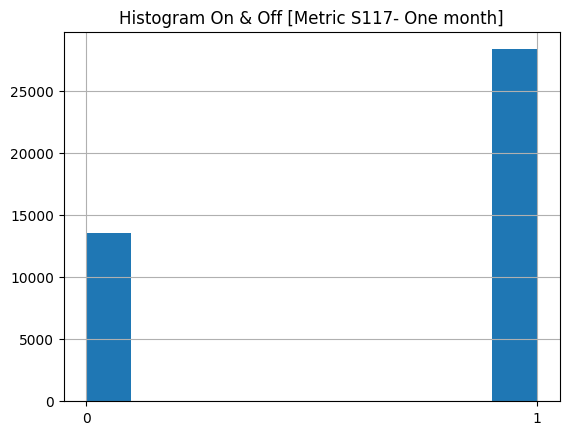

In [31]:
# To Pandas
# engine on and off during a month
df_r_1machine.filter(F.month(F.col('when'))==10).toPandas()['value'].hist()
plt.title('Histogram On & Off [Metric S117- One month]')
plt.show()

## 4. Anomaly Detection

The metrics/variable that containes the information for the turning on/off the engines
are:
- S117 (engine 1)
- S118 (engine 2)
- S169 (engine 3)
- S170 (engine 4)

In [32]:
metric_engines = ['S117','S118','S169','S170']

In [33]:
# get dataframe for each machine

df_sw065 = df_r[df_r.hwid==list_machines[0][0]]
df_sw088 = df_r[df_r.hwid==list_machines[1][0]]
df_sw106 = df_r[df_r.hwid==list_machines[2][0]]
df_sw115 = df_r[df_r.hwid==list_machines[3][0]]

In [34]:
df_sw065.printSchema()

root
 |-- when: string (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: string (nullable = true)
 |-- when_resampled: string (nullable = true)



### 4.1 Machine SW065 - Analysis

We selected one Machine to perfome the analysis of the frequency.

#### a)  Engine S117

In [35]:
# select one engine
df_sw065_s117 = df_sw065[df_sw065.metric == metric_engines[0]]

In [36]:
# perform a downsampling with the columns when_resampled and get a "new_value"
df_sw065_downsampling = df_sw065_s117.groupBy(['when_resampled','hwid','metric'])\
                .agg(F.max('value').cast('integer').alias('new_value'))\
                .sort('when_resampled')

df_sw065_downsampling = df_sw065_downsampling.withColumnRenamed('when_resampled','when')\
                                            .withColumnRenamed('new_value','value')

In [37]:
# show results
df_sw065_downsampling.show(60)

+-------------------+------+------+-----+
|               when|  hwid|metric|value|
+-------------------+------+------+-----+
|2020-10-01 00:01:00|SW-065|  S117|    0|
|2020-10-01 00:02:00|SW-065|  S117|    0|
|2020-10-01 00:03:00|SW-065|  S117|    0|
|2020-10-01 00:04:00|SW-065|  S117|    0|
|2020-10-01 00:05:00|SW-065|  S117|    0|
|2020-10-01 00:06:00|SW-065|  S117|    0|
|2020-10-01 00:07:00|SW-065|  S117|    0|
|2020-10-01 00:08:00|SW-065|  S117|    0|
|2020-10-01 00:09:00|SW-065|  S117|    0|
|2020-10-01 00:10:00|SW-065|  S117|    1|
|2020-10-01 00:11:00|SW-065|  S117|    1|
|2020-10-01 00:12:00|SW-065|  S117|    1|
|2020-10-01 00:13:00|SW-065|  S117|    1|
|2020-10-01 00:14:00|SW-065|  S117|    1|
|2020-10-01 00:16:00|SW-065|  S117|    1|
|2020-10-01 00:17:00|SW-065|  S117|    1|
|2020-10-01 00:18:00|SW-065|  S117|    1|
|2020-10-01 00:19:00|SW-065|  S117|    1|
|2020-10-01 00:20:00|SW-065|  S117|    1|
|2020-10-01 00:21:00|SW-065|  S117|    1|
|2020-10-01 00:22:00|SW-065|  S117

In [38]:
df_sw065_downsampling.select(F.min(F.col('when')),F.max(F.col('when'))).show()

+-------------------+-------------------+
|          min(when)|          max(when)|
+-------------------+-------------------+
|2020-10-01 00:01:00|2021-01-13 12:14:00|
+-------------------+-------------------+



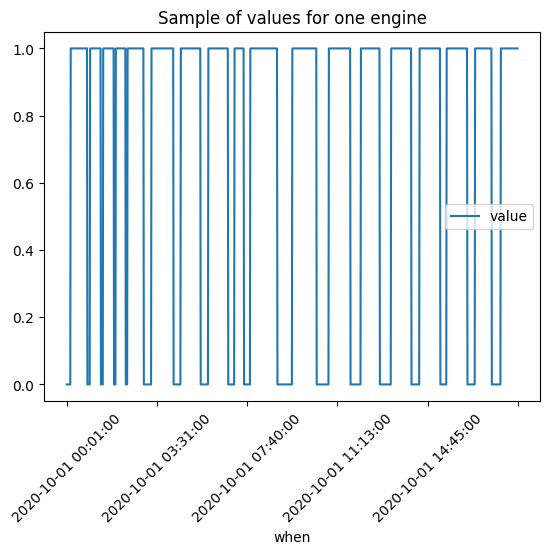

In [39]:
# plot ON-OFF values
df_sw065_downsampling.toPandas()[:1000].plot(x='when',y='value')
#plt.xlabel('Records')
plt.xticks(rotation=45)
plt.title('Sample of values for one engine')
plt.show()

In [40]:
# Add a lag column to calculate the difference 
window = Window.partitionBy("metric").orderBy("when")
df_1 = df_sw065_downsampling.withColumn("lag_value", F.lag(F.col("value")).over(window))

## ON and OFF events
df_1 = df_1.withColumn("ON-OFF", F.when(F.col("value") > F.col("lag_value"), 1).when((F.col("value") < F.col("lag_value")) | F.isnull(F.col("lag_value")) , -1).otherwise(0))


In [41]:
df_1.show(60)

+-------------------+------+------+-----+---------+------+
|               when|  hwid|metric|value|lag_value|ON-OFF|
+-------------------+------+------+-----+---------+------+
|2020-10-01 00:01:00|SW-065|  S117|    0|     null|    -1|
|2020-10-01 00:02:00|SW-065|  S117|    0|        0|     0|
|2020-10-01 00:03:00|SW-065|  S117|    0|        0|     0|
|2020-10-01 00:04:00|SW-065|  S117|    0|        0|     0|
|2020-10-01 00:05:00|SW-065|  S117|    0|        0|     0|
|2020-10-01 00:06:00|SW-065|  S117|    0|        0|     0|
|2020-10-01 00:07:00|SW-065|  S117|    0|        0|     0|
|2020-10-01 00:08:00|SW-065|  S117|    0|        0|     0|
|2020-10-01 00:09:00|SW-065|  S117|    0|        0|     0|
|2020-10-01 00:10:00|SW-065|  S117|    1|        0|     1|
|2020-10-01 00:11:00|SW-065|  S117|    1|        1|     0|
|2020-10-01 00:12:00|SW-065|  S117|    1|        1|     0|
|2020-10-01 00:13:00|SW-065|  S117|    1|        1|     0|
|2020-10-01 00:14:00|SW-065|  S117|    1|        1|     

In [42]:
# time diff in seconds between turn ON and OFF
diff_btw_rows = F.unix_timestamp(F.col('when')) - F.unix_timestamp(F.lag(F.col('when'),1,0).over(window))

df_2 = df_1.filter(F.col('ON-OFF') != 0)

df_2 = df_2.withColumn('window', F.round(F.coalesce(diff_btw_rows, F.lit(0) )/60 ).cast('integer') )



In [43]:
df_2.show(60)

+-------------------+------+------+-----+---------+------+------+
|               when|  hwid|metric|value|lag_value|ON-OFF|window|
+-------------------+------+------+-----+---------+------+------+
|2020-10-01 00:01:00|SW-065|  S117|    0|     null|    -1|     0|
|2020-10-01 00:10:00|SW-065|  S117|    1|        0|     1|     9|
|2020-10-01 00:48:00|SW-065|  S117|    0|        1|    -1|    38|
|2020-10-01 00:54:00|SW-065|  S117|    1|        0|     1|     6|
|2020-10-01 01:19:00|SW-065|  S117|    0|        1|    -1|    25|
|2020-10-01 01:24:00|SW-065|  S117|    1|        0|     1|     5|
|2020-10-01 01:49:00|SW-065|  S117|    0|        1|    -1|    25|
|2020-10-01 01:54:00|SW-065|  S117|    1|        0|     1|     5|
|2020-10-01 02:20:00|SW-065|  S117|    0|        1|    -1|    26|
|2020-10-01 02:25:00|SW-065|  S117|    1|        0|     1|     5|
|2020-10-01 03:01:00|SW-065|  S117|    0|        1|    -1|    36|
|2020-10-01 03:19:00|SW-065|  S117|    1|        0|     1|    18|
|2020-10-0

- Filter dataset: reduce to one month of year 2020

In [44]:
# filter ONE month and ONE year
df_2 = df_2.filter((F.year(F.col('when'))==2020)&(F.month(F.col('when'))==10))

In [45]:

# filter time window of On-Off

# df of time window from On to Off 
df_2_OnOff = df_2.filter(F.col('ON-OFF') == -1).toPandas()
# df of time window from Off to On
df_2_OffOn = df_2.filter(F.col('ON-OFF') == 1).toPandas()

In [46]:
df_2_OnOff

,when,hwid,metric,value,lag_value,ON-OFF,window
0,2020-10-01 00:01:00,SW-065,S117,0,NaN,-1,0
1,2020-10-01 00:48:00,SW-065,S117,0,1.0,-1,38
2,2020-10-01 01:19:00,SW-065,S117,0,1.0,-1,25
3,2020-10-01 01:49:00,SW-065,S117,0,1.0,-1,25
4,2020-10-01 02:20:00,SW-065,S117,0,1.0,-1,26
...,...,...,...,...,...,...,...
908,2020-10-31 22:00:00,SW-065,S117,0,1.0,-1,24
909,2020-10-31 22:29:00,SW-065,S117,0,1.0,-1,23
910,2020-10-31 22:58:00,SW-065,S117,0,1.0,-1,23
911,2020-10-31 23:28:00,SW-065,S117,0,1.0,-1,24


In [47]:
df_2_OffOn

,when,hwid,metric,value,lag_value,ON-OFF,window
0,2020-10-01 00:10:00,SW-065,S117,1,0,1,9
1,2020-10-01 00:54:00,SW-065,S117,1,0,1,6
2,2020-10-01 01:24:00,SW-065,S117,1,0,1,5
3,2020-10-01 01:54:00,SW-065,S117,1,0,1,5
4,2020-10-01 02:25:00,SW-065,S117,1,0,1,5
...,...,...,...,...,...,...,...
907,2020-10-31 21:36:00,SW-065,S117,1,0,1,7
908,2020-10-31 22:06:00,SW-065,S117,1,0,1,6
909,2020-10-31 22:35:00,SW-065,S117,1,0,1,6
910,2020-10-31 23:04:00,SW-065,S117,1,0,1,6


In [48]:
# most frequent values
df_2.groupby('window').count().orderBy(F.desc('count')).show()

+------+-----+
|window|count|
+------+-----+
|     5|   98|
|     6|   89|
|    24|   81|
|    16|   75|
|    18|   74|
|    23|   72|
|    48|   71|
|    49|   68|
|    15|   67|
|    17|   67|
|    14|   67|
|    13|   64|
|    10|   55|
|    47|   53|
|    19|   52|
|    20|   46|
|    22|   43|
|     7|   41|
|    11|   39|
|    50|   38|
+------+-----+
only showing top 20 rows



Frequency in minutes: 48.96


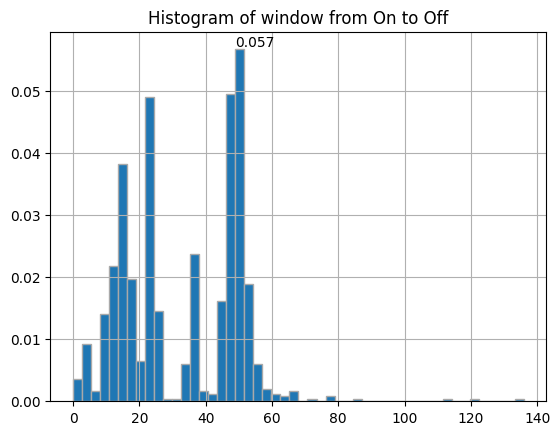

In [49]:
# histogram of the period of engine turned ON before being turned Off

# Plot histogram
#plt.figure()
y, x, _ = plt.hist(df_2_OnOff['window'], histtype='bar', density=True, edgecolor='darkgray', bins=50)

# Compute the max value (plt.hist returns the x and y positions of the bars)
ymax = y.max()
idx = np.where(y == ymax)[0][0]
xval = x[idx]

# Annotate the highest value
plt.gca().text(xval, ymax, np.round(ymax,3), ha='left', va='bottom')

print("Frequency in minutes:",xval)

#df_2_OffOn['window'].hist(density=True,bins=50)
#plt.xlim(0,20)

plt.title('Histogram of window from On to Off')
plt.grid()
plt.show()

Frequency in minutes: 4.279999999999999


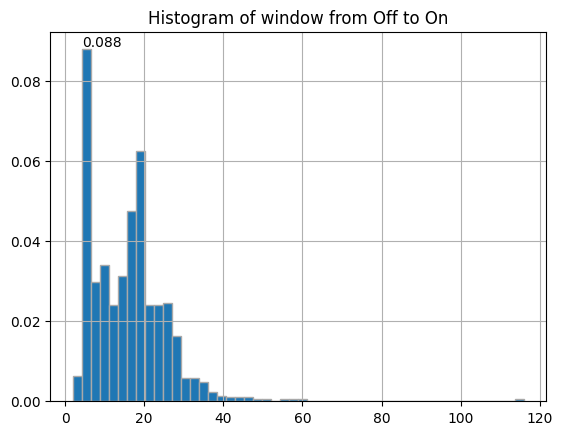

In [50]:
# histogram of the period of engine turned OFF before being turned ON

# Plot histogram
#plt.figure()
y, x, _ = plt.hist(df_2_OffOn['window'], histtype='bar', density=True, edgecolor='darkgray', bins=50)

# Compute the max value (plt.hist returns the x and y positions of the bars)
ymax = y.max()
idx = np.where(y == ymax)[0][0]
xval = x[idx]

# Annotate the highest value
plt.gca().text(xval, ymax, np.round(ymax,3), ha='left', va='bottom')

print("Frequency in minutes:",xval)

#df_2_OffOn['window'].hist(density=True,bins=50)
#plt.xlim(0,20)

plt.title('Histogram of window from Off to On')
plt.grid()
plt.show()

Notes: It resembles to a Gaussian-like distribution so we will use z-score. Z-score is the difference between the value and the sample mean expressed as the number of standard deviations.

In [51]:
# Z-score
from scipy.stats import zscore

# check for outliers

df_2_OffOn["age_zscore"] = zscore(df_2_OffOn["window"])
df_2_OffOn["is_outlier"] = df_2_OffOn["age_zscore"].apply(
  lambda x: x <= -2.5 or x >= 2.5
)
df_2_OffOn[df_2_OffOn["is_outlier"]]

,when,hwid,metric,value,lag_value,ON-OFF,window,age_zscore,is_outlier
21,2020-10-01 23:25:00,SW-065,S117,1,0,1,41,2.647634,True
22,2020-10-02 01:07:00,SW-065,S117,1,0,1,44,2.964059,True
23,2020-10-02 02:53:00,SW-065,S117,1,0,1,45,3.069534,True
24,2020-10-02 04:45:00,SW-065,S117,1,0,1,46,3.175009,True
89,2020-10-05 02:12:00,SW-065,S117,1,0,1,59,4.546186,True
116,2020-10-06 14:26:00,SW-065,S117,1,0,1,52,3.807860,True
128,2020-10-07 06:14:00,SW-065,S117,1,0,1,41,2.647634,True
165,2020-10-09 01:58:00,SW-065,S117,1,0,1,49,3.491435,True
353,2020-10-14 08:06:00,SW-065,S117,1,0,1,40,2.542159,True
408,2020-10-16 07:39:00,SW-065,S117,1,0,1,58,4.440711,True


0     44
1     45
2     46
3     59
4     52
5     49
6     58
7     47
8    116
9     55
Name: Outliers, dtype: int32


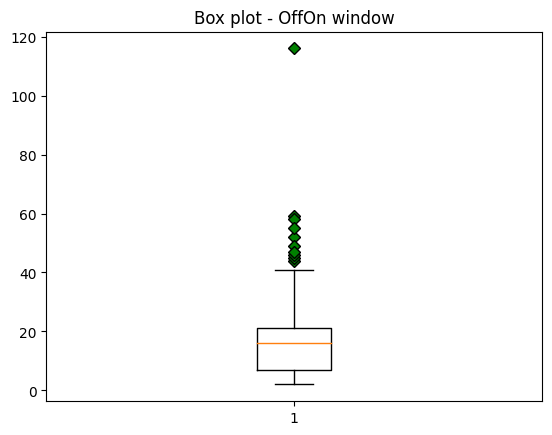

In [52]:
# box plot to check for outliers

green_diamond = dict(markerfacecolor='g', marker='D')

fig3, ax3 = plt.subplots()
ax3.set_title('Box plot - OffOn window')
boxplot_dict = ax3.boxplot(df_2_OffOn['window'], flierprops=green_diamond)
# Extract the outliers
outliers = boxplot_dict['fliers'][0].get_ydata()

# Convert outliers to a pandas Series
outliers_series = pd.Series(outliers, name='Outliers')

print(outliers_series)

In [ ]:
# Find the indices of the outliers in the DataFrame
#outlier_indices = df_2_OffOn.index[df_2_OffOn['window'].isin(outliers)].tolist()

In [ ]:
# Correlation between all the columns of DataFrame.
#df2 = df_2['value'].corr()
#print(df2)

#### Analyzing the time windows of turn On and Off

We analyze over one month period

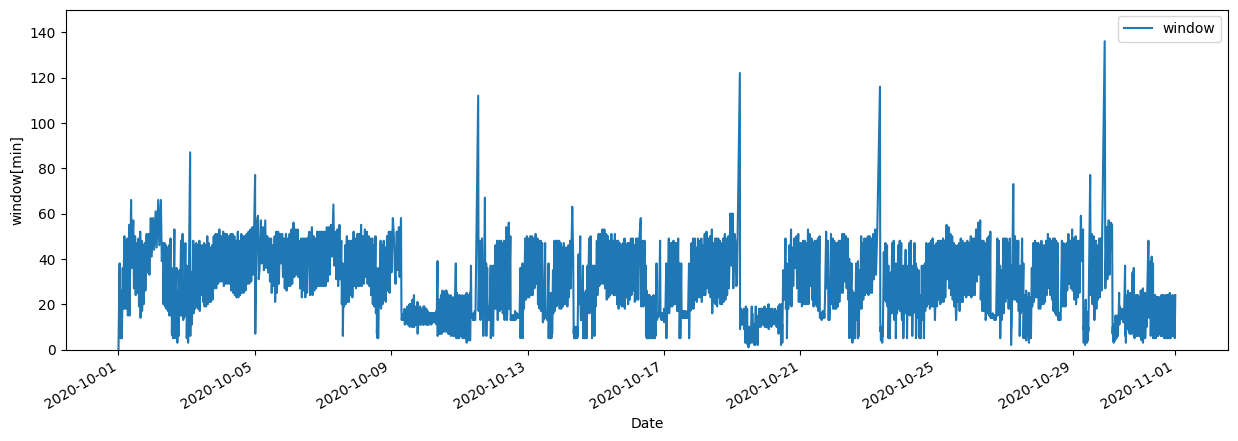

In [53]:
# convert pyspark df to Pandas of one month
df_2_pd = df_2.toPandas()

df_2_pd['Date'] = pd.to_datetime(df_2_pd['when'])

fig, ax1 = plt.subplots(figsize=(15,5))
df_2_pd.plot(x='Date',y='window', ax = ax1)

plt.ylim(0,150)
#plt.xticks(np.arange(31))
plt.ylabel('window[min]')
plt.show()

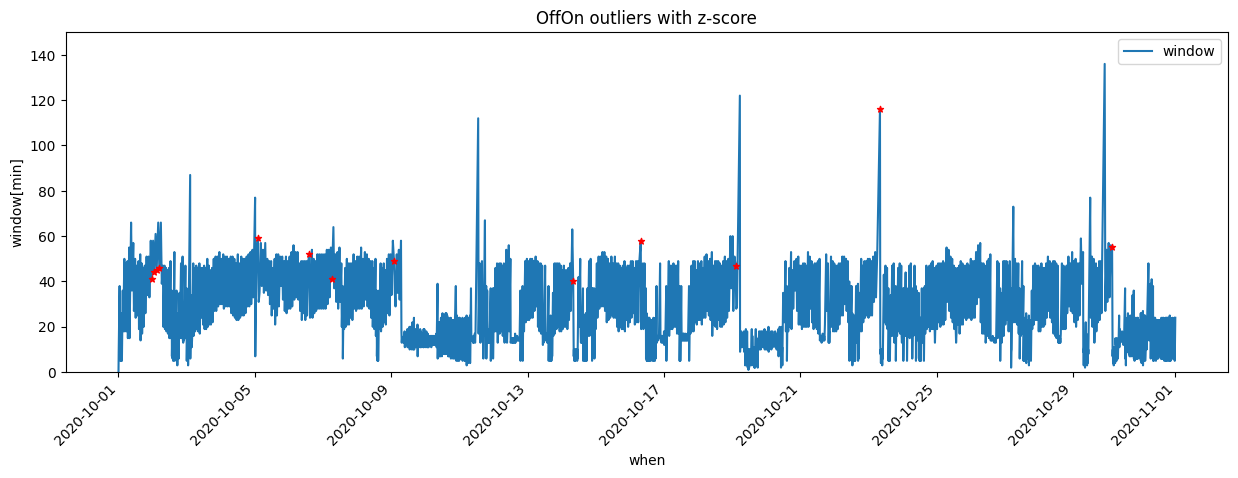

In [54]:
# add outliers from z-score

df_2_pd = df_2.toPandas()

df_2_pd['Date'] = pd.to_datetime(df_2_pd['when'])

fig, ax1 = plt.subplots(figsize=(15,5))
df_2_pd.plot(x='Date',y='window',ax=ax1,zorder=1)
df_2_OffOn[df_2_OffOn["is_outlier"]].plot.scatter(x='when',y='window', ax=ax1, color='r',marker='*',zorder=2)

plt.ylim(0,150)
#plt.xticks(np.arange(31))
plt.xticks(rotation=45)
plt.ylabel('window[min]')
plt.title('OffOn outliers with z-score')
plt.show()

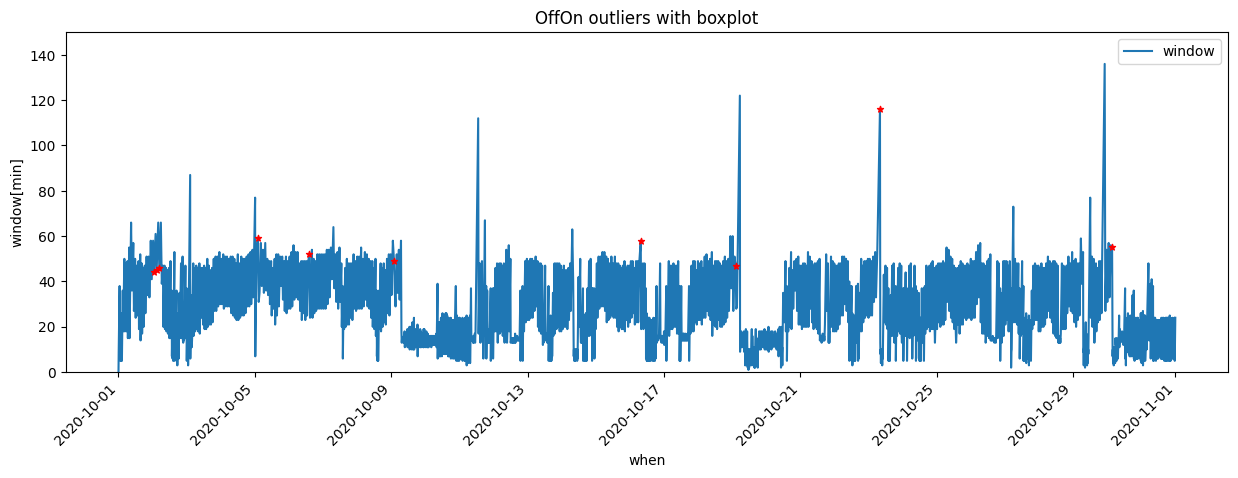

In [55]:
#df_2_OffOn.index[df_2_OffOn['window'].isin(outliers)]

df_2_pd = df_2.toPandas()

df_2_pd['Date'] = pd.to_datetime(df_2_pd['when'])

fig, ax1 = plt.subplots(figsize=(15,5))
df_2_pd.plot(x='Date',y='window',ax=ax1,zorder=1)
df_2_OffOn[df_2_OffOn['window'].isin(outliers)].plot.scatter(x='when',y='window', ax=ax1, color='r',marker='*',zorder=2)

plt.ylim(0,150)
#plt.xticks(np.arange(31))
plt.xticks(rotation=45)
plt.ylabel('window[min]')
plt.title('OffOn outliers with boxplot')
plt.show()

- Model to detect outliers: K-Means

In [56]:
df_2 = df_1.filter(F.col('ON-OFF') != 0)

df_2 = df_2.withColumn('window', F.round(F.coalesce(diff_btw_rows, F.lit(0) )/60 ).cast('integer') )

In [57]:
# filter ONE month and ONE year - to Pandas
df_2_pd = df_2.filter((F.year(F.col('when'))==2020)&(F.month(F.col('when'))==10)).toPandas()

In [58]:
# values
xx = df_2_pd[['value','window']]#.values

In [59]:
from sklearn.cluster import KMeans

# initiate model
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(xx)

# label predictions
labels = kmeans.predict(xx)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

# calculate distance
def get_distancebypoint(data, model):
    """ Calculates the distance between a point and centroid of a cluster, returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

# Get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = get_distancebypoint(xx, kmeans)


# We assume that 1% of the entire data set are anomalies 
outliers_fraction = 0.01

# Number of observations
number_of_outliers = int(outliers_fraction*len(distance))

# Take the minimum of the largest outliers_fraction of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()

# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df_2_pd['anomaly1'] = (distance >= threshold).astype(int)

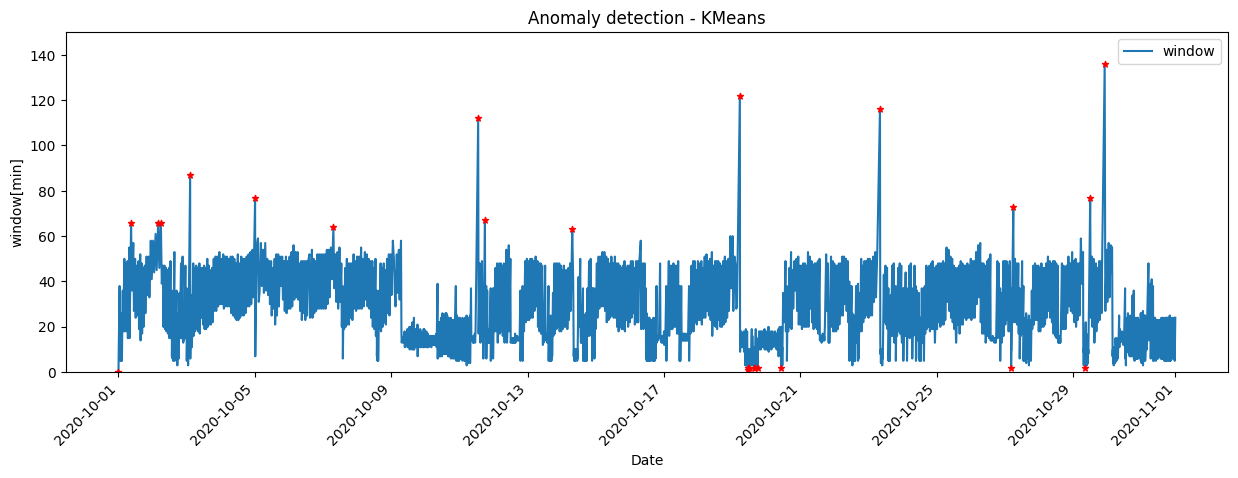

In [60]:
# Plotting

# to datetime
df_2_pd['Date'] = pd.to_datetime(df_2_pd['when'])


fig, ax2 = plt.subplots(figsize=(15,5))

#ax2.plot(df_2_pd['window'].values)
df_2_pd.plot(x='Date',y='window',ax=ax2,zorder=1)

# Scatter plot for anomalies
df_2_pd[df_2_pd['anomaly1'] == 1].plot(x='Date', y='window', kind='scatter', ax=ax2, color='r', marker='*', zorder=2)

# Set plot limits and labels
plt.ylim(0, 150)
plt.xticks(rotation=45)
plt.ylabel('window[min]')
plt.title('Anomaly detection - KMeans')

# Display the plot
plt.show()


- Filtering the signal

cutoff=  4.999999999999999  days


Text(0, 0.5, 'window[min]')

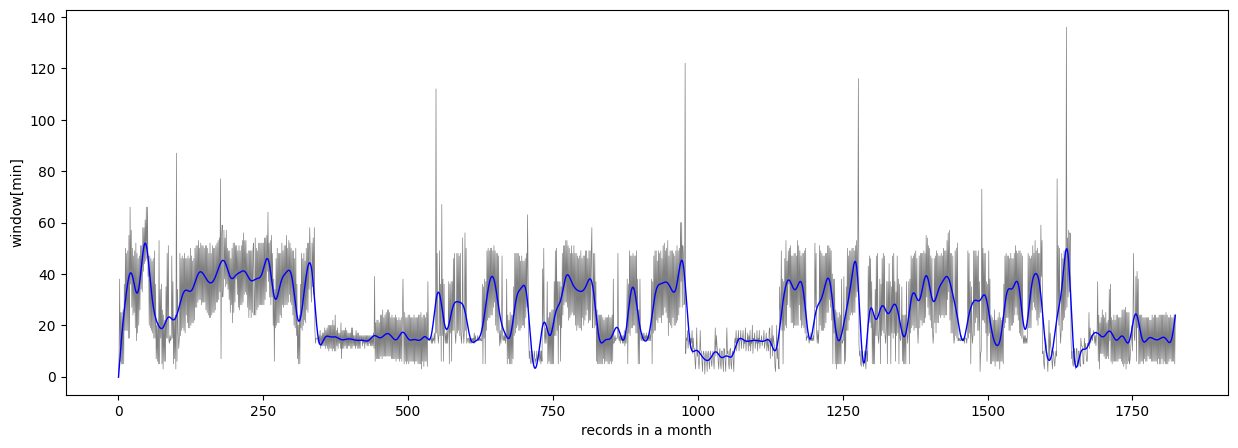

In [61]:
from scipy import signal
fs=1/24/3600 #1 day in Hz (sampling frequency)

nyquist = fs / 2 # 0.5 times the sampling frequency
cutoff=0.1 # fraction of nyquist frequency, here  it is 5 days
print('cutoff= ',1/cutoff*nyquist*24*3600,' days') #cutoff=  4.999999999999999  days
b, a = signal.butter(5, cutoff, btype='lowpass') #low pass filter

xx = df_2_pd['window'].values

x_filt = signal.filtfilt(b, a, xx)
x_filt=np.array(x_filt)
x_filt=x_filt.transpose()

#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot(xx,'k-',lw=0.5,alpha=0.5)

ax1.plot(x_filt,'b',linewidth=1)

#df_2_OffOn[df_2_OffOn["is_outlier"]].plot.scatter(x='when',y='window', ax=ax1, color='r',marker='*',zorder=2)

ax1.set_xlabel('records in a month')#,fontsize=18)
ax1.set_ylabel('window[min]')#,fontsize=18)
#plt.savefig('test.png',dpi=150,bbox_inches='tight')

cutoff=  4.999999999999999  days


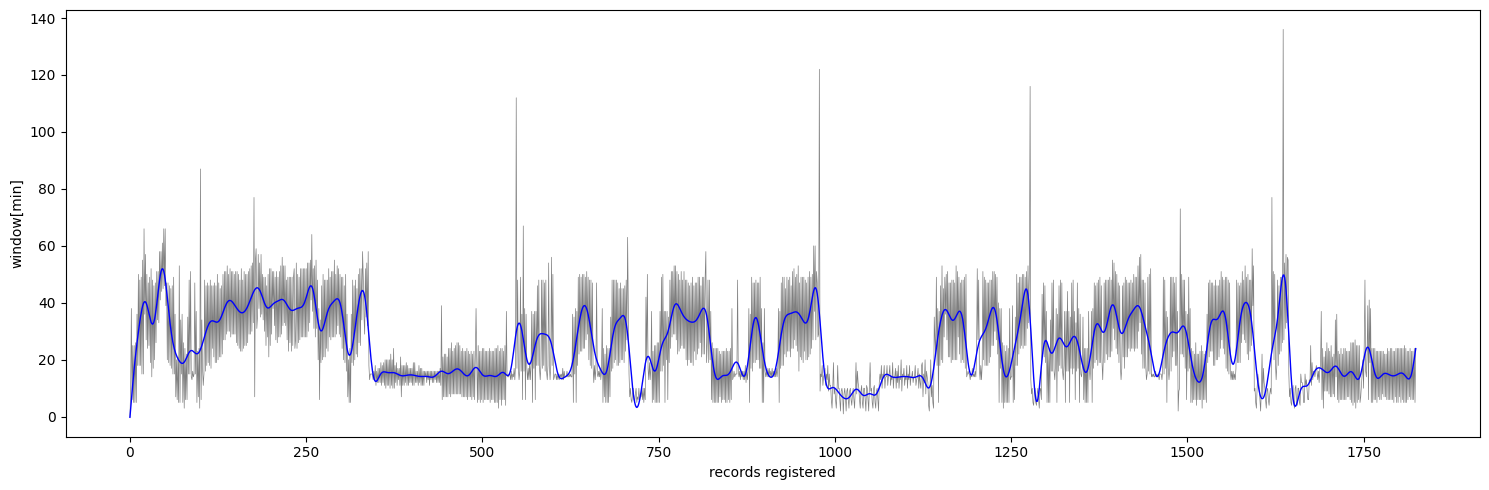

In [62]:
from scipy import signal
fs=1/24/3600 #1 day in Hz (sampling frequency)

nyquist = fs / 2 # 0.5 times the sampling frequency
cutoff=0.1 # fraction of nyquist frequency, here  it is 5 days
print('cutoff= ',1/cutoff*nyquist*24*3600,' days') #cutoff=  4.999999999999999  days
b, a = signal.butter(5, cutoff, btype='lowpass') #low pass filter

xx = df_2_pd['window'].values

x_filt = signal.filtfilt(b, a, xx)
x_filt=np.array(x_filt)
x_filt=x_filt.transpose()

#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot(xx,'k-',lw=0.5,alpha=0.5)

ax1.plot(x_filt,'b',linewidth=1)

#df_2_OffOn[df_2_OffOn["is_outlier"]].plot.scatter(x='when',y='window', ax=ax1, color='r',marker='*',zorder=2)

ax1.set_xlabel('records registered')#,fontsize=18)
ax1.set_ylabel('window[min]')#,fontsize=18)
#plt.savefig('test.png',dpi=150,bbox_inches='tight')

fig.tight_layout()


- Autocorrelation

Analysis measures the relationship of the observations between the different points in time, and thus seeks a pattern or trend over the time series.

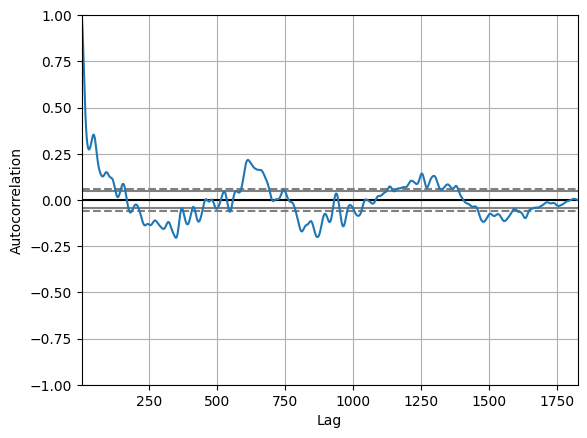

In [63]:
# autocorrelation

autocorrelation_plot(x_filt)
plt.show()

#### FFT - frequency analysis

1825


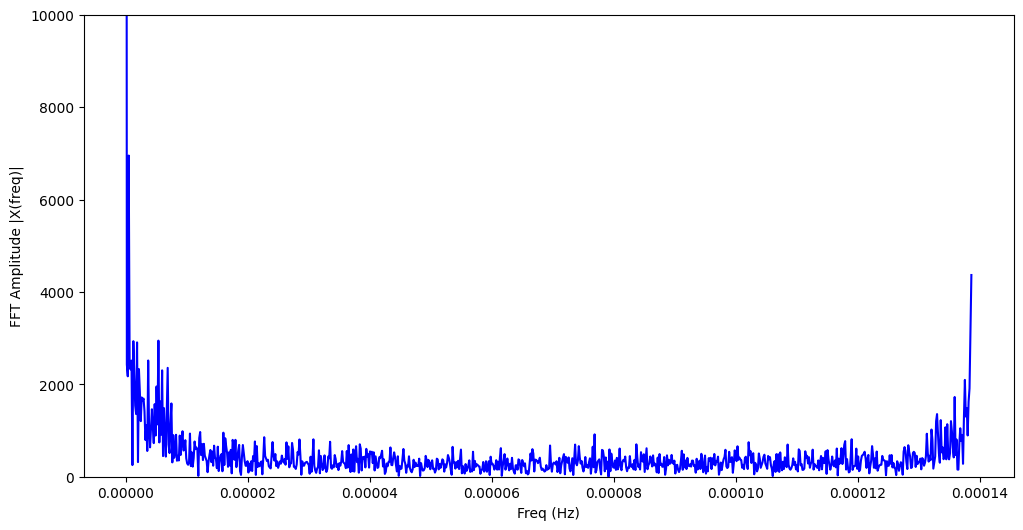

In [64]:
xx = df_2_pd['window'].values

X = fft(xx)
N = len(X)
print(N)
n = np.arange(N)
# get the sampling rate
sr = 1 / (60*60)
T = N/sr
freq = n/T 

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

plt.figure(figsize = (12, 6))
plt.plot(f_oneside, np.abs(X[:n_oneside]), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.ylim(0,10000)
plt.show()

/tmp/ipykernel_13/514017203.py:2: RuntimeWarning: divide by zero encountered in divide
  t_h = 1/f_oneside / (60 * 60)


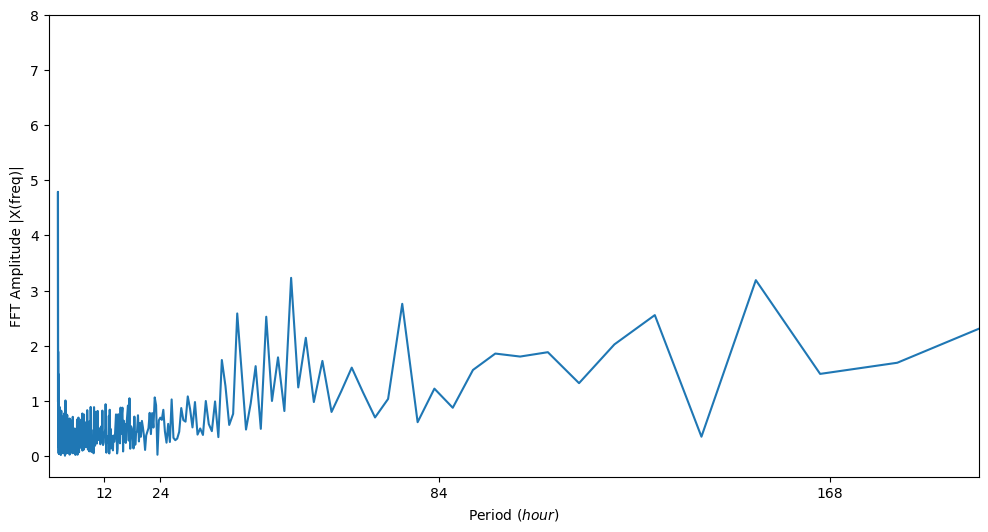

In [65]:
# convert frequency to hour
t_h = 1/f_oneside / (60 * 60)

plt.figure(figsize=(12,6))
plt.plot(t_h, np.abs(X[:n_oneside])/n_oneside)
plt.xticks([12, 24, 84, 168])
plt.xlim(0, 200)
plt.xlabel('Period ($hour$)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.show()

- High-pass filter

cut-off frequency: 5


/opt/conda/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


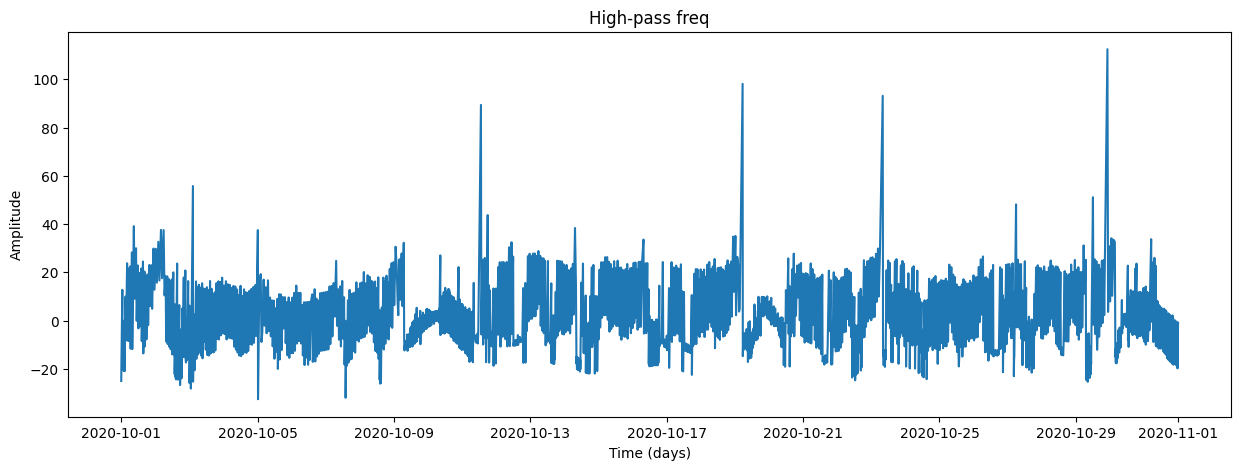

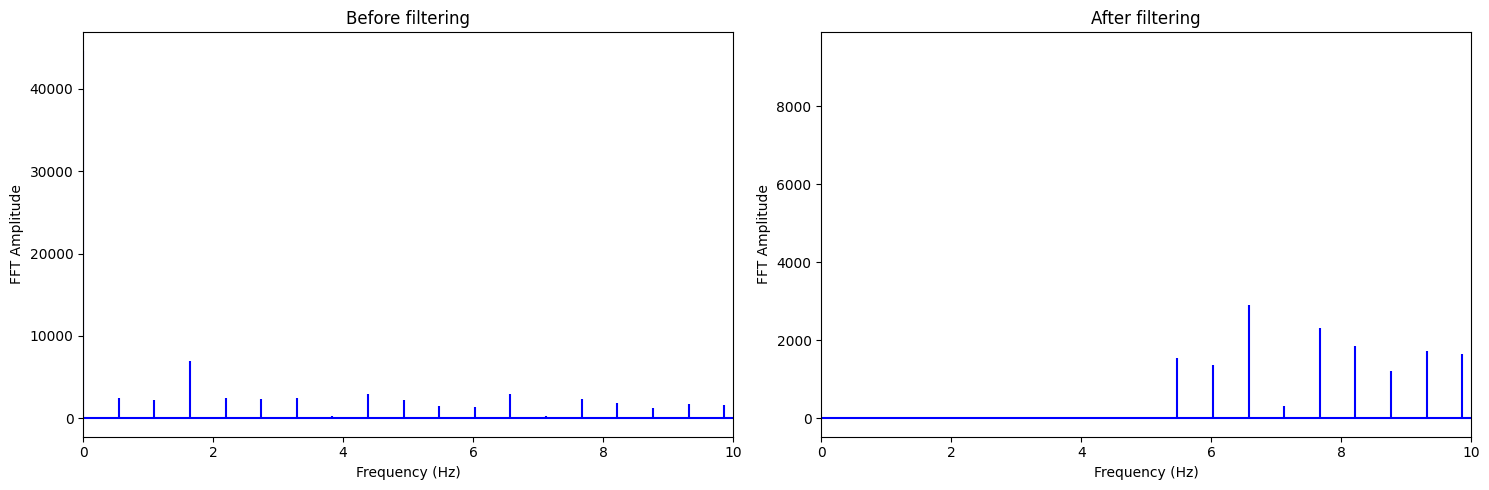

In [66]:
xx = df_2_pd['window'].values

# FFT the signal
sig_fft = fft(xx)
# copy the FFT results
sig_fft_filtered = sig_fft.copy()

# obtain the frequencies using scipy function
freq = fftfreq(len(xx), d=1./1000)

# define the cut-off frequency
cut_off = 5
print('cut-off frequency:',5)

# high-pass filter by assign zeros to the 
# FFT amplitudes where the absolute 
# frequencies smaller than the cut-off 
sig_fft_filtered[np.abs(freq) < cut_off] = 0

# get the filtered signal in time domain
filtered = ifft(sig_fft_filtered)

# plot the filtered signal
plt.figure(figsize = (15, 5))
plt.plot(df_2_pd.Date,filtered)
plt.xlabel('Time (days)')
plt.ylabel('Amplitude')
plt.title('High-pass freq')
plt.show()

# plot the FFT amplitude before and after
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.stem(freq, np.abs(sig_fft), 'b', \
         markerfmt=" ", basefmt="-b")
plt.title('Before filtering')
plt.xlim(0, 10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')
plt.subplot(122)
plt.stem(freq, np.abs(sig_fft_filtered), 'b', \
         markerfmt=" ", basefmt="-b")
plt.title('After filtering')
plt.xlim(0, 10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')
plt.tight_layout()
plt.show()

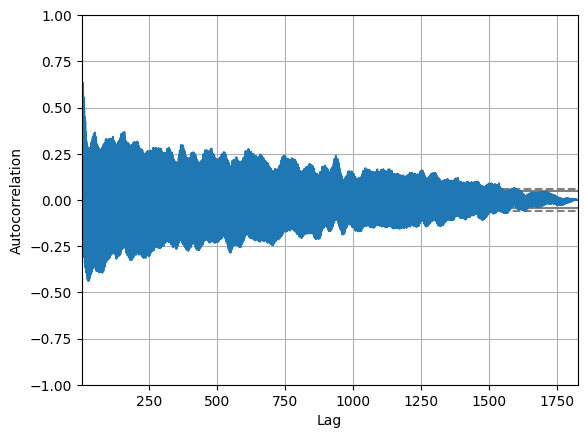

In [67]:
# autocorrelation
autocorrelation_plot(filtered)
plt.show()

- Low-pass filter

cut-off frequency: 5


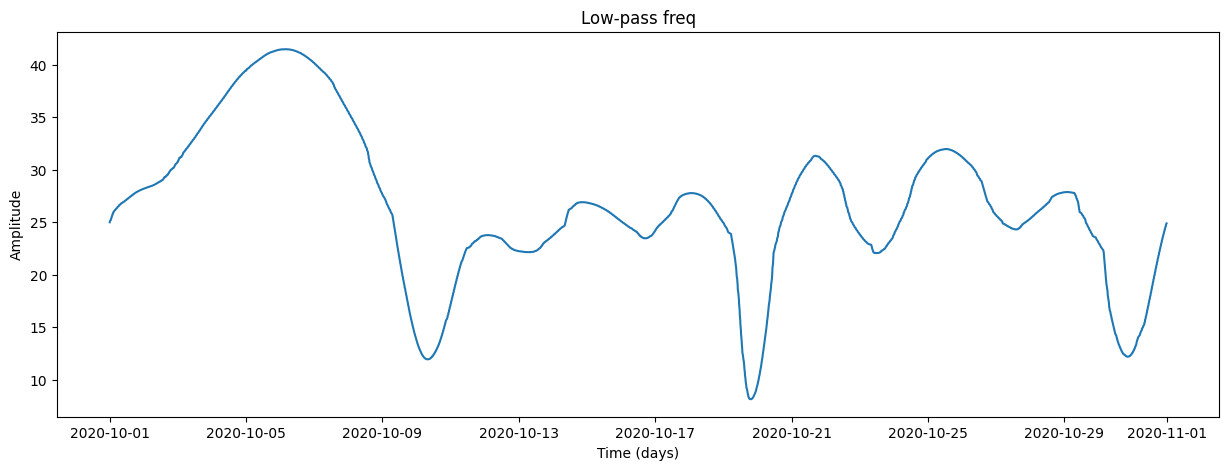

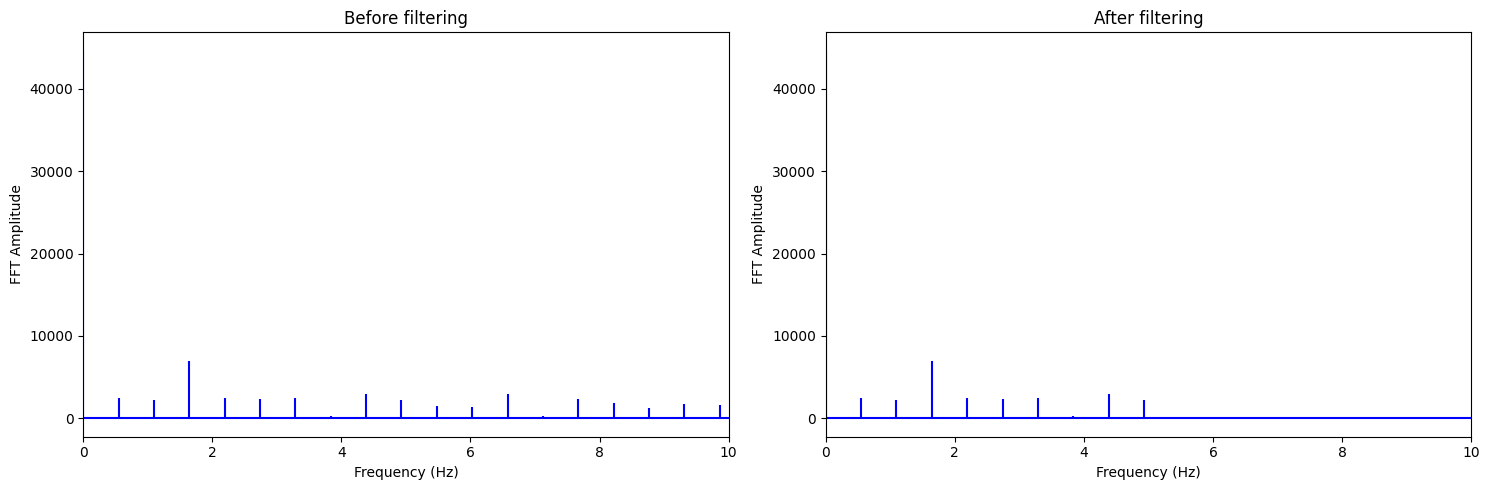

In [68]:
xx = df_2_pd['window'].values

# FFT the signal
sig_fft = fft(xx)
# copy the FFT results
sig_fft_filtered = sig_fft.copy()

# obtain the frequencies using scipy function
freq = fftfreq(len(xx), d=1./1000)

# define the cut-off frequency
cut_off = 5
print('cut-off frequency:',5)

# low-pass filter by assign zeros to the 
# FFT amplitudes where the absolute 
# frequencies greater than the cut-off 
sig_fft_filtered[np.abs(freq) > cut_off] = 0

# get the filtered signal in time domain
filtered = ifft(sig_fft_filtered)

# plot the filtered signal
plt.figure(figsize = (15, 5))
plt.plot(df_2_pd.Date,filtered)
plt.xlabel('Time (days)')
plt.ylabel('Amplitude')
plt.title('Low-pass freq')
plt.show()

# plot the FFT amplitude before and after
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.stem(freq, np.abs(sig_fft), 'b', \
         markerfmt=" ", basefmt="-b")
plt.title('Before filtering')
plt.xlim(0, 10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')
plt.subplot(122)
plt.stem(freq, np.abs(sig_fft_filtered), 'b', \
         markerfmt=" ", basefmt="-b")
plt.title('After filtering')
plt.xlim(0, 10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')
plt.tight_layout()
plt.show()

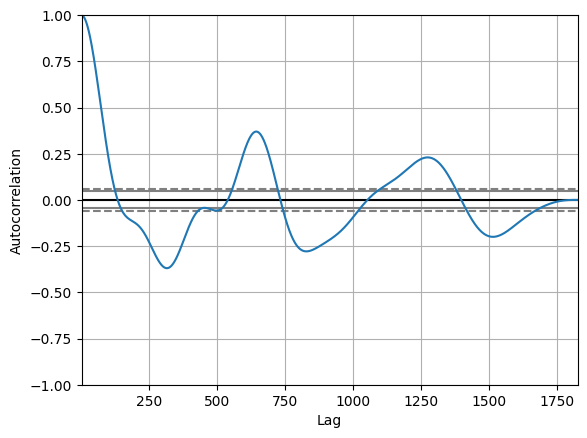

In [69]:
# autocorrelation
autocorrelation_plot(filtered)
plt.show()

### Summary of each Engine

#### a) Engine S117

In [70]:
# select one engine
df_sw065_s117 = df_sw065[df_sw065.metric == metric_engines[0]]

In [71]:
# perform a downsampling with the columns when_resampled and get a "new_value"
df_sw065_downsampling = df_sw065_s117.groupBy(['when_resampled','hwid','metric'])\
                .agg(F.max('value').cast('integer').alias('new_value'))\
                .sort('when_resampled')

df_sw065_downsampling = df_sw065_downsampling.withColumnRenamed('when_resampled','when')\
                                            .withColumnRenamed('new_value','value')

#df_sw065_downsampling.show(60)

In [72]:
# Add a lag column to calculate the difference 
window = Window.partitionBy("metric").orderBy("when")
df_1 = df_sw065_downsampling.withColumn("lag_value", F.lag(F.col("value")).over(window))

## ON and OFF events
df_1 = df_1.withColumn("ON-OFF", F.when(F.col("value") > F.col("lag_value"), 1).when((F.col("value") < F.col("lag_value")) | F.isnull(F.col("lag_value")) , -1).otherwise(0))

In [73]:
# time diff in seconds between turn ON and OFF
diff_btw_rows = F.unix_timestamp(F.col('when')) - F.unix_timestamp(F.lag(F.col('when'),1,0).over(window))

df_2 = df_1.filter(F.col('ON-OFF') != 0)

df_2 = df_2.withColumn('window', F.round(F.coalesce(diff_btw_rows, F.lit(0) )/60 ).cast('integer') )

In [74]:
# most frequent values
df_2.groupby('window').count().orderBy(F.desc('count')).show()

+------+-----+
|window|count|
+------+-----+
|     5|  233|
|    14|  184|
|    15|  184|
|    16|  179|
|    23|  166|
|    13|  153|
|    24|  144|
|    10|  140|
|     6|  140|
|     9|  136|
|    22|  121|
|    11|  120|
|    17|  112|
|     8|  110|
|    18|  101|
|     7|   93|
|    12|   92|
|    19|   81|
|    48|   76|
|    49|   73|
+------+-----+
only showing top 20 rows



In [75]:
# complete data 

df_2_pd = df_2.toPandas()

# values
xx = df_2_pd[['value','window']]#.values

from sklearn.cluster import KMeans

# initiate model
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(xx)

# label predictions
labels = kmeans.predict(xx)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

# Get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = get_distancebypoint(xx, kmeans)


# We assume that 1% of the entire data set are anomalies 
outliers_fraction = 0.01

# Number of observations
number_of_outliers = int(outliers_fraction*len(distance))

# Take the minimum of the largest outliers_fraction of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()

# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df_2_pd['anomaly1'] = (distance >= threshold).astype(int)

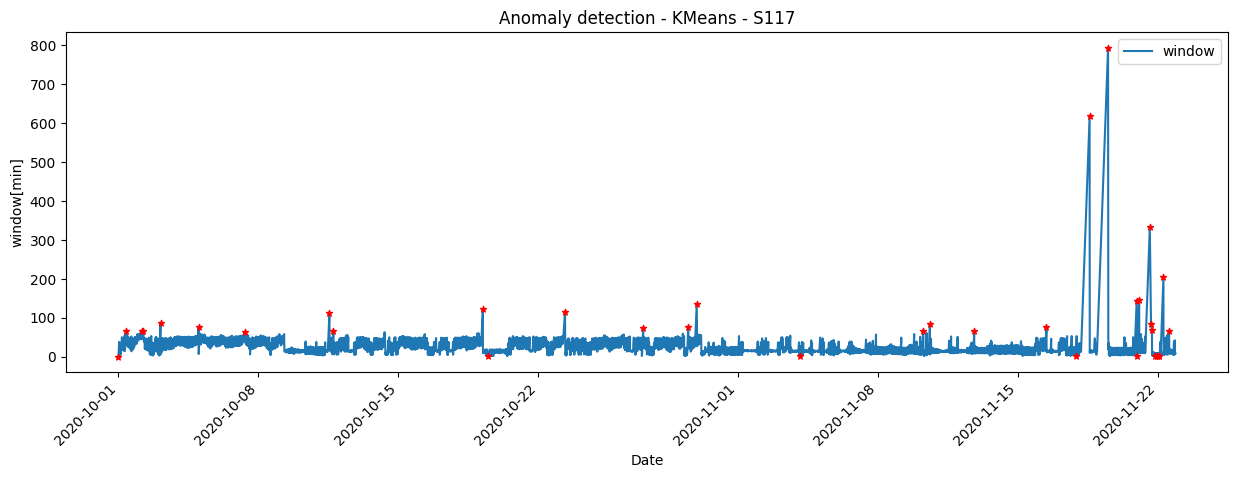

In [76]:
# Plotting

# to datetime
df_2_pd['Date'] = pd.to_datetime(df_2_pd['when'])


fig, ax2 = plt.subplots(figsize=(15,5))

#ax2.plot(df_2_pd['window'].values)
df_2_pd.plot(x='Date',y='window',ax=ax2,zorder=1)

# Scatter plot for anomalies
df_2_pd[df_2_pd['anomaly1'] == 1].plot(x='Date', y='window', kind='scatter', ax=ax2, color='r', marker='*', zorder=2)

# Set plot limits and labels
#plt.ylim(0, 60)
plt.xticks(rotation=45)
plt.ylabel('window[min]')
plt.title('Anomaly detection - KMeans - S117')

# Display the plot
plt.show()

#### b) Engine S118

In [77]:
# select one engine
df_sw065_s118 = df_sw065[df_sw065.metric == metric_engines[1]]

In [78]:
# perform a downsampling with the columns when_resampled and get a "new_value"
df_sw065_downsampling = df_sw065_s118.groupBy(['when_resampled','hwid','metric'])\
                .agg(F.max('value').cast('integer').alias('new_value'))\
                .sort('when_resampled')

df_sw065_downsampling = df_sw065_downsampling.withColumnRenamed('when_resampled','when')\
                                            .withColumnRenamed('new_value','value')

#df_sw065_downsampling.show(60)

In [79]:
# Add a lag column to calculate the difference 
window = Window.partitionBy("metric").orderBy("when")
df_1 = df_sw065_downsampling.withColumn("lag_value", F.lag(F.col("value")).over(window))

## ON and OFF events
df_1 = df_1.withColumn("ON-OFF", F.when(F.col("value") > F.col("lag_value"), 1).when((F.col("value") < F.col("lag_value")) | F.isnull(F.col("lag_value")) , -1).otherwise(0))

In [80]:
# time diff in seconds between turn ON and OFF
diff_btw_rows = F.unix_timestamp(F.col('when')) - F.unix_timestamp(F.lag(F.col('when'),1,0).over(window))

df_2 = df_1.filter(F.col('ON-OFF') != 0)

df_2 = df_2.withColumn('window', F.round(F.coalesce(diff_btw_rows, F.lit(0) )/60 ).cast('integer') )

In [81]:
# most frequent values
df_2.groupby('window').count().orderBy(F.desc('count')).show()

+------+-----+
|window|count|
+------+-----+
|     5|  185|
|     6|  168|
|    23|  106|
|    24|   98|
|    22|   91|
|     7|   75|
|     8|   57|
|    21|   54|
|    25|   41|
|     9|   40|
|    26|   35|
|    10|   24|
|    16|   15|
|     4|   14|
|    20|   12|
|    15|   12|
|    11|   11|
|    27|   11|
|     3|   10|
|    14|    8|
+------+-----+
only showing top 20 rows



In [82]:
# complete data 

df_2_pd = df_2.toPandas()

# values
xx = df_2_pd[['value','window']]#.values

from sklearn.cluster import KMeans

# initiate model
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(xx)

# label predictions
labels = kmeans.predict(xx)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

# Get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = get_distancebypoint(xx, kmeans)


# We assume that 1% of the entire data set are anomalies 
outliers_fraction = 0.01

# Number of observations
number_of_outliers = int(outliers_fraction*len(distance))

# Take the minimum of the largest outliers_fraction of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()

# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df_2_pd['anomaly1'] = (distance >= threshold).astype(int)

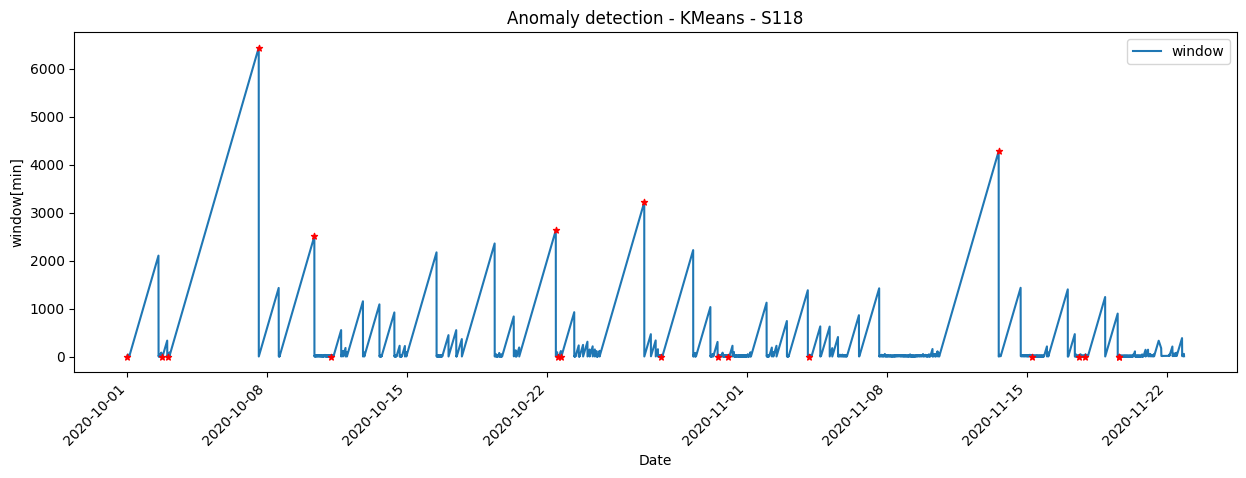

In [83]:
# Plotting

# to datetime
df_2_pd['Date'] = pd.to_datetime(df_2_pd['when'])


fig, ax2 = plt.subplots(figsize=(15,5))

#ax2.plot(df_2_pd['window'].values)
df_2_pd.plot(x='Date',y='window',ax=ax2,zorder=1)

# Scatter plot for anomalies
df_2_pd[df_2_pd['anomaly1'] == 1].plot(x='Date', y='window', kind='scatter', ax=ax2, color='r', marker='*', zorder=2)

# Set plot limits and labels
#plt.ylim(0, 60)
plt.xticks(rotation=45)
plt.ylabel('window[min]')
plt.title('Anomaly detection - KMeans - S118')

# Display the plot
plt.show()

#### c) Engine S169

In [84]:
# select one engine
df_sw065_s169 = df_sw065[df_sw065.metric == metric_engines[2]]

In [85]:
# perform a downsampling with the columns when_resampled and get a "new_value"
df_sw065_downsampling = df_sw065_s169.groupBy(['when_resampled','hwid','metric'])\
                .agg(F.max('value').cast('integer').alias('new_value'))\
                .sort('when_resampled')

df_sw065_downsampling = df_sw065_downsampling.withColumnRenamed('when_resampled','when')\
                                            .withColumnRenamed('new_value','value')

#df_sw065_downsampling.show(60)

In [86]:
# Add a lag column to calculate the difference 
window = Window.partitionBy("metric").orderBy("when")
df_1 = df_sw065_downsampling.withColumn("lag_value", F.lag(F.col("value")).over(window))

## ON and OFF events
df_1 = df_1.withColumn("ON-OFF", F.when(F.col("value") > F.col("lag_value"), 1).when((F.col("value") < F.col("lag_value")) | F.isnull(F.col("lag_value")) , -1).otherwise(0))

In [87]:
# time diff in seconds between turn ON and OFF
diff_btw_rows = F.unix_timestamp(F.col('when')) - F.unix_timestamp(F.lag(F.col('when'),1,0).over(window))

df_2 = df_1.filter(F.col('ON-OFF') != 0)

df_2 = df_2.withColumn('window', F.round(F.coalesce(diff_btw_rows, F.lit(0) )/60 ).cast('integer') )

In [88]:
# most frequent values
df_2.groupby('window').count().orderBy(F.desc('count')).show()

+------+-----+
|window|count|
+------+-----+
|    14|  212|
|     5|  198|
|    15|  178|
|    13|  176|
|    23|  164|
|    16|  153|
|     6|  150|
|    17|  136|
|    24|  134|
|    22|  132|
|     7|  123|
|    12|  117|
|    11|  113|
|    10|  109|
|    25|  108|
|    18|   99|
|     9|   84|
|    48|   84|
|     8|   81|
|    49|   75|
+------+-----+
only showing top 20 rows



In [89]:
# complete data 

df_2_pd = df_2.toPandas()

# values
xx = df_2_pd[['value','window']]#.values

from sklearn.cluster import KMeans

# initiate model
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(xx)

# label predictions
labels = kmeans.predict(xx)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

# Get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = get_distancebypoint(xx, kmeans)


# We assume that 1% of the entire data set are anomalies 
outliers_fraction = 0.01

# Number of observations
number_of_outliers = int(outliers_fraction*len(distance))

# Take the minimum of the largest outliers_fraction of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()

# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df_2_pd['anomaly1'] = (distance >= threshold).astype(int)

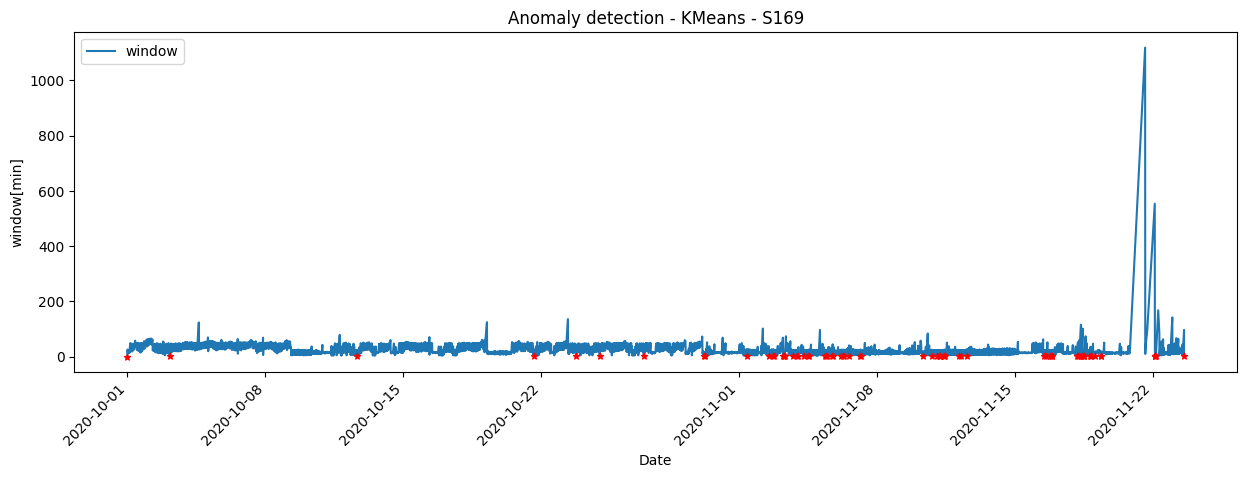

In [90]:
# Plotting

# to datetime
df_2_pd['Date'] = pd.to_datetime(df_2_pd['when'])


fig, ax2 = plt.subplots(figsize=(15,5))

#ax2.plot(df_2_pd['window'].values)
df_2_pd.plot(x='Date',y='window',ax=ax2,zorder=1)

# Scatter plot for anomalies
df_2_pd[df_2_pd['anomaly1'] == 1].plot(x='Date', y='window', kind='scatter', ax=ax2, color='r', marker='*', zorder=2)

# Set plot limits and labels
#plt.ylim(0, 60)
plt.xticks(rotation=45)
plt.ylabel('window[min]')
plt.title('Anomaly detection - KMeans - S169')

# Display the plot
plt.show()

#### d) Engine S170

In [91]:
# select one engine
df_sw065_s170 = df_sw065[df_sw065.metric == metric_engines[3]]

In [92]:
# perform a downsampling with the columns when_resampled and get a "new_value"
df_sw065_downsampling = df_sw065_s170.groupBy(['when_resampled','hwid','metric'])\
                .agg(F.max('value').cast('integer').alias('new_value'))\
                .sort('when_resampled')

df_sw065_downsampling = df_sw065_downsampling.withColumnRenamed('when_resampled','when')\
                                            .withColumnRenamed('new_value','value')

#df_sw065_downsampling.show(60)

In [93]:
# Add a lag column to calculate the difference 
window = Window.partitionBy("metric").orderBy("when")
df_1 = df_sw065_downsampling.withColumn("lag_value", F.lag(F.col("value")).over(window))

## ON and OFF events
df_1 = df_1.withColumn("ON-OFF", F.when(F.col("value") > F.col("lag_value"), 1).when((F.col("value") < F.col("lag_value")) | F.isnull(F.col("lag_value")) , -1).otherwise(0))

In [94]:
# time diff in seconds between turn ON and OFF
diff_btw_rows = F.unix_timestamp(F.col('when')) - F.unix_timestamp(F.lag(F.col('when'),1,0).over(window))

df_2 = df_1.filter(F.col('ON-OFF') != 0)

df_2 = df_2.withColumn('window', F.round(F.coalesce(diff_btw_rows, F.lit(0) )/60 ).cast('integer') )

In [95]:
# most frequent values
df_2.groupby('window').count().orderBy(F.desc('count')).show()

+------+-----+
|window|count|
+------+-----+
|     5|  169|
|     6|  159|
|    23|  124|
|    22|  113|
|    24|  100|
|     7|   91|
|     8|   70|
|    25|   70|
|     9|   46|
|    26|   38|
|     4|   28|
|    10|   25|
|    27|   19|
|    11|   18|
|    21|   18|
|    28|   14|
|    12|   10|
|    29|    8|
|    20|    8|
|    30|    7|
+------+-----+
only showing top 20 rows



In [96]:
# complete data 

df_2_pd = df_2.toPandas()

# values
xx = df_2_pd[['value','window']]#.values

from sklearn.cluster import KMeans

# initiate model
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(xx)

# label predictions
labels = kmeans.predict(xx)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

# Get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = get_distancebypoint(xx, kmeans)


# We assume that 1% of the entire data set are anomalies 
outliers_fraction = 0.01

# Number of observations
number_of_outliers = int(outliers_fraction*len(distance))

# Take the minimum of the largest outliers_fraction of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()

# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df_2_pd['anomaly1'] = (distance >= threshold).astype(int)

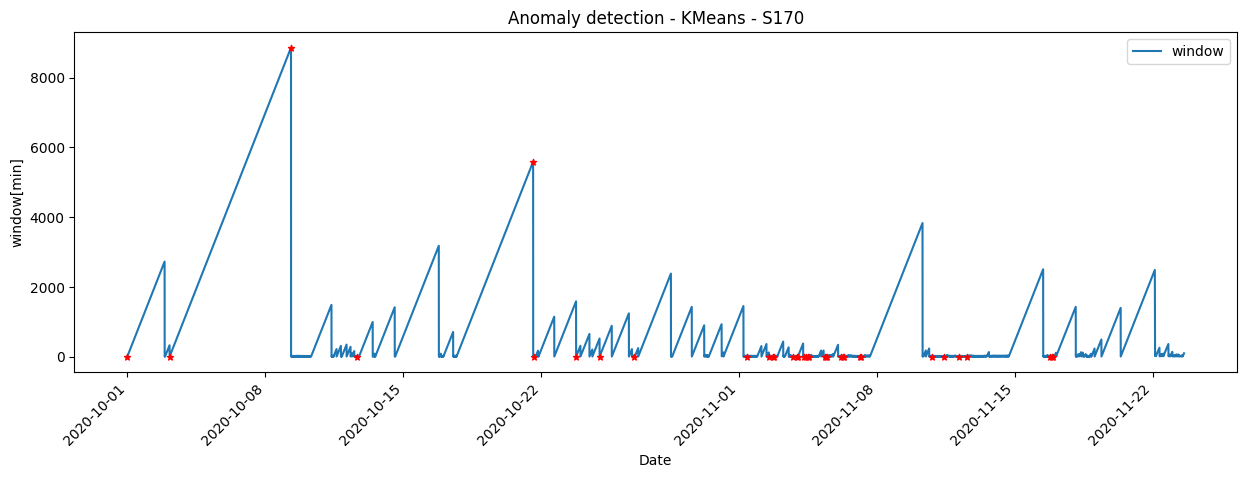

In [97]:
# Plotting

# to datetime
df_2_pd['Date'] = pd.to_datetime(df_2_pd['when'])


fig, ax2 = plt.subplots(figsize=(15,5))

#ax2.plot(df_2_pd['window'].values)
df_2_pd.plot(x='Date',y='window',ax=ax2,zorder=1)

# Scatter plot for anomalies
df_2_pd[df_2_pd['anomaly1'] == 1].plot(x='Date', y='window', kind='scatter', ax=ax2, color='r', marker='*', zorder=2)

# Set plot limits and labels
#plt.ylim(0, 60)
plt.xticks(rotation=45)
plt.ylabel('window[min]')
plt.title('Anomaly detection - KMeans - S170')

# Display the plot
plt.show()

Notes: three out of four engines have a turn On-OFF frequency every 5 min, except for engine S169. However, if we considere the windows of 5 and 6 min, we can see that those windows are more often. 

## 5. Correlation Analysis

In [98]:
# get dataframe for each machine

df_sw065 = df_r[df_r.hwid==list_machines[0][0]]
df_sw088 = df_r[df_r.hwid==list_machines[1][0]]
df_sw106 = df_r[df_r.hwid==list_machines[2][0]]
df_sw115 = df_r[df_r.hwid==list_machines[3][0]]

- Machine SW065

In [99]:
# perform a downsampling with the columns when_resampled and get a "new_value"
df_sw065_downsampling = df_sw065.groupBy(['when_resampled','hwid','metric'])\
                .agg(F.max('value').cast('integer').alias('new_value'))\
                .sort('when_resampled')

df_sw065_downsampling = df_sw065_downsampling.withColumnRenamed('when_resampled','when')\
                                            .withColumnRenamed('new_value','value')

In [100]:
#df_sw065_downsampling.show(60)

In [101]:
df_sw065_downsampling = df_sw065_downsampling.persist()

In [102]:
# fist and lasta date record
df_sw065_downsampling.select(F.min(F.col('when')),F.max(F.col('when'))).show()

+-------------------+-------------------+
|          min(when)|          max(when)|
+-------------------+-------------------+
|2020-10-01 00:01:00|2021-01-13 12:14:00|
+-------------------+-------------------+



- Machine SW088

In [103]:
# perform a downsampling with the columns when_resampled and get a "new_value"
df_sw088_downsampling = df_sw088.groupBy(['when_resampled','hwid','metric'])\
                .agg(F.max('value').cast('integer').alias('new_value'))\
                .sort('when_resampled')

df_sw088_downsampling = df_sw088_downsampling.withColumnRenamed('when_resampled','when')\
                                            .withColumnRenamed('new_value','value')

In [104]:
#df_sw088_downsampling.show(60)

In [105]:
# fist and lasta date record
df_sw088_downsampling.select(F.min(F.col('when')),F.max(F.col('when'))).show()

+-------------------+-------------------+
|          min(when)|          max(when)|
+-------------------+-------------------+
|2020-10-01 00:00:00|2021-03-31 23:59:00|
+-------------------+-------------------+



- Machine SW106

In [106]:
# perform a downsampling with the columns when_resampled and get a "new_value"
df_sw106_downsampling = df_sw106.groupBy(['when_resampled','hwid','metric'])\
                .agg(F.max('value').cast('integer').alias('new_value'))\
                .sort('when_resampled')

df_sw106_downsampling = df_sw106_downsampling.withColumnRenamed('when_resampled','when')\
                                            .withColumnRenamed('new_value','value')

In [107]:
#df_sw106_downsampling.show(60)

In [108]:
# fist and lasta date record
df_sw106_downsampling.select(F.min(F.col('when')),F.max(F.col('when'))).show()

+-------------------+-------------------+
|          min(when)|          max(when)|
+-------------------+-------------------+
|2020-10-01 00:00:00|2021-03-27 07:28:00|
+-------------------+-------------------+



- Machine SW115

In [110]:
# perform a downsampling with the columns when_resampled and get a "new_value"
df_sw115_downsampling = df_sw115.groupBy(['when_resampled','hwid','metric'])\
                .agg(F.max('value').cast('integer').alias('new_value'))\
                .sort('when_resampled')

df_sw115_downsampling = df_sw115_downsampling.withColumnRenamed('when_resampled','when')\
                                            .withColumnRenamed('new_value','value')

In [111]:
#df_sw115_downsampling.show(60)

### Machine SW106

We selected the same machine as before and filter by the windows with a frequency of turning Off-On of 5 min. This mean that its been 5 min from last turn Off.

In [112]:
# Add a lag column to calculate the difference 
window = Window.partitionBy("metric").orderBy("when")
df_sw065_1 = df_sw065_downsampling.withColumn("lag_value", F.lag(F.col("value")).over(window))

## ON and OFF events
df_sw065_1 = df_sw065_1.withColumn("ON-OFF", F.when(F.col("value") > F.col("lag_value"), 1).when((F.col("value") < F.col("lag_value")) | F.isnull(F.col("lag_value")) , -1).otherwise(0))

# time diff in seconds between turn ON and OFF
diff_btw_rows = F.unix_timestamp(F.col('when')) - F.unix_timestamp(F.lag(F.col('when'),1,0).over(window))

df_sw065_1 = df_sw065_1.filter(F.col('ON-OFF') != 0)
df_sw065_1 = df_sw065_1.withColumn('window', F.round(F.coalesce(diff_btw_rows, F.lit(0) )/60 ).cast('integer') )

df_sw065_1 = df_sw065_1.persist()

In [113]:
# filtered by most frequent window
window_cutoff = 5
df_sw065_when_hig_freq = df_sw065_1.filter((F.col('ON-OFF') == 1) & (F.col('window') < window_cutoff)).select('when').sort('when')

# join tables
df_sw065_hig_freq = df_sw065_1.join(df_sw065_when_hig_freq, how='inner', on='when').sort(F.col('when'))

df_sw065_hig_freq = df_sw065_hig_freq.select('when','metric','value').persist()
#df_sw065_hig_freq.unpersist()

In [114]:
df_sw065_hig_freq.show()

+-------------------+------+-----+
|               when|metric|value|
+-------------------+------+-----+
|2020-10-01 00:02:00|   S39|  150|
|2020-10-01 00:02:00|   S39|  150|
|2020-10-01 00:02:00|   S39|  150|
|2020-10-01 00:02:00|   S39|  150|
|2020-10-01 00:02:00|   S39|  150|
|2020-10-01 00:02:00|   S10|   20|
|2020-10-01 00:02:00|   S10|   20|
|2020-10-01 00:02:00|   S10|   20|
|2020-10-01 00:02:00|   S10|   20|
|2020-10-01 00:02:00|   S10|   20|
|2020-10-01 00:02:00|  S178|  436|
|2020-10-01 00:02:00|  S178|  436|
|2020-10-01 00:02:00|  S178|  436|
|2020-10-01 00:02:00|  S178|  436|
|2020-10-01 00:02:00|  S178|  436|
|2020-10-01 00:02:00|  S102|  144|
|2020-10-01 00:02:00|  S102|  144|
|2020-10-01 00:02:00|  S102|  144|
|2020-10-01 00:02:00|  S102|  144|
|2020-10-01 00:02:00|  S102|  144|
+-------------------+------+-----+
only showing top 20 rows



#### Correlations

In [115]:
# get a list of metrics
metric_list = df_sw065_hig_freq.select('metric').distinct().rdd.map(lambda x: x.metric).collect()
metric_list.sort()


In [116]:
print(metric_list)

['A5', 'A9', 'S10', 'S100', 'S102', 'S109', 'S112', 'S117', 'S118', 'S122', 'S125', 'S126', 'S128', 'S130', 'S138', 'S151', 'S157', 'S159', 'S166', 'S169', 'S170', 'S171', 'S178', 'S181', 'S201', 'S204', 'S39', 'S40', 'S41', 'S5', 'S53', 'S71', 'S73', 'S81', 'S94']


In [117]:
# pivot the dataframe - converts rows to column
df_sw065_pivot = df_sw065_hig_freq.groupby('when').pivot('metric').sum('value')

In [118]:
df_sw065_pivot.show(10)

24/07/08 08:51:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+-------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+----+----+----+----+----+----+----+----+----+
|               when|  A5|  A9| S10|S100|S102|S109|S112|S117|S118|S122|S125|S126|S128|S130|S138|S151|S157|S159|S166|S169|S170|S171|S178|S181| S201| S204| S39| S40| S41|  S5| S53| S71| S73| S81| S94|
+-------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+----+----+----+----+----+----+----+----+----+
|2020-10-01 00:02:00|null|null| 100|null| 720|2010|null|null|null|null|null|  65|null|null| 260|null|null|1025|null|null|null|null|2180|null| null|35895| 750| 675|null|null|null|null|null| 225|null|
|2020-10-01 00:03:00|nul

- Handle missing values

In [121]:
def find_column_missing_percentage(df):
    """
    Takes a PySpark DataFrame as input and returns a dictionary with
    columns that have missing values and the percentage of missing values in each column.
    """
    
    # Calculate the total number of rows in the DataFrame
    total_rows = df.count()

    # Use DataFrame's 'agg' method to apply count and when functions
    # This will count the number of null or NaN values for each column
    missing_count_df = df.agg(*[F.count(F.when(F.isnull(c) | F.isnan(c), c)).alias(c) for c in df.columns])

    # Collect the result into a dictionary
    missing_count = missing_count_df.collect()[0].asDict()

    # Calculate the percentage of missing values for each column and store in a dictionary
    missing_percentage = {column: (value / total_rows) * 100 for column, value in missing_count.items()}
    missing_num = {column: value for column, value in missing_count.items()}

    # Filter out columns with no missing values
    missing_percentage = {column: value for column, value in missing_percentage.items() if value > 0}

    missing_percentage = spark.createDataFrame([(k, v) for k, v in missing_percentage.items()], ["Variables","Percent_Missing"])
    missing_percent = missing_percentage.withColumn("Percent_Missing", F.round(missing_percentage["Percent_Missing"], 2))
    missing_percent = missing_percent.sort("Percent_Missing", ascending=False)

    return missing_percent


# call function
missing_values_col = find_column_missing_percentage(df_sw065_pivot)

In [122]:
# See results
missing_values_col.show(140)

+---------+---------------+
|Variables|Percent_Missing|
+---------+---------------+
|       A5|          100.0|
|       A9|          100.0|
|      S53|          100.0|
|     S171|          99.63|
|     S112|           99.6|
|     S118|          98.69|
|     S170|          98.65|
|     S130|          97.47|
|      S73|          97.32|
|     S169|          96.17|
|     S181|          96.17|
|     S125|          96.09|
|     S117|          96.09|
|       S5|          92.29|
|     S126|           87.4|
|     S128|          85.02|
|      S71|          84.91|
|     S151|          77.98|
|      S94|          77.91|
|     S100|          74.95|
|     S157|          74.35|
|     S204|          69.39|
|     S201|          68.82|
|      S10|          66.94|
|     S109|          57.66|
|     S166|          56.83|
|     S178|          55.88|
|     S122|          54.76|
|     S159|          52.18|
|     S102|           51.6|
|      S39|           46.7|
|      S41|          44.29|
|     S138|         

Notes: missing values are present datetime data not available for the complete time period

#### Impute missing values in dataframe

When there are missing values in data, we have the following options

- Approach 1: Drop the row that has missing values.
- Approach 2: Drop the entire column if most of the values in the column has missing values.
- Approach 3: Impute the missing data, that is, fill in the missing values with appropriate values (like mean, median, mode..). However, the easiest impute is to fill with zeros.
- Approach 4: Use an ML algorithm that handles missing values on its own, internally

- Approach 3

In [123]:
# Fill missing values with a default value
default_value = 0
df_sw065_imputed = df_sw065_pivot.fillna(default_value)

In [124]:
#df_sw065_imputed.show()

In [128]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# define function for correlation btw variables
def get_correlation(df, list_of_columns):
    # convert to vector column first
    vector_col = "corr_features"
    ## we drop the alarms A5 and A9
    assembler = VectorAssembler(inputCols=df.select(list_of_columns).columns, outputCol = vector_col)
    df_vector = assembler.transform(df.select(list_of_columns)).select(vector_col)

    # get correlation matrix
    matrix = Correlation.corr(df_vector, vector_col).collect()[0][0] 
    corr_matrix = matrix.toArray().tolist() 
    corr_matrix_df = pd.DataFrame(data = corr_matrix, columns = list_of_columns)

    return corr_matrix_df

# drop A5 and A9 - metric_list[2:]
corr_matrix_df = get_correlation(df_sw065_imputed, metric_list[2:])

<Axes: >

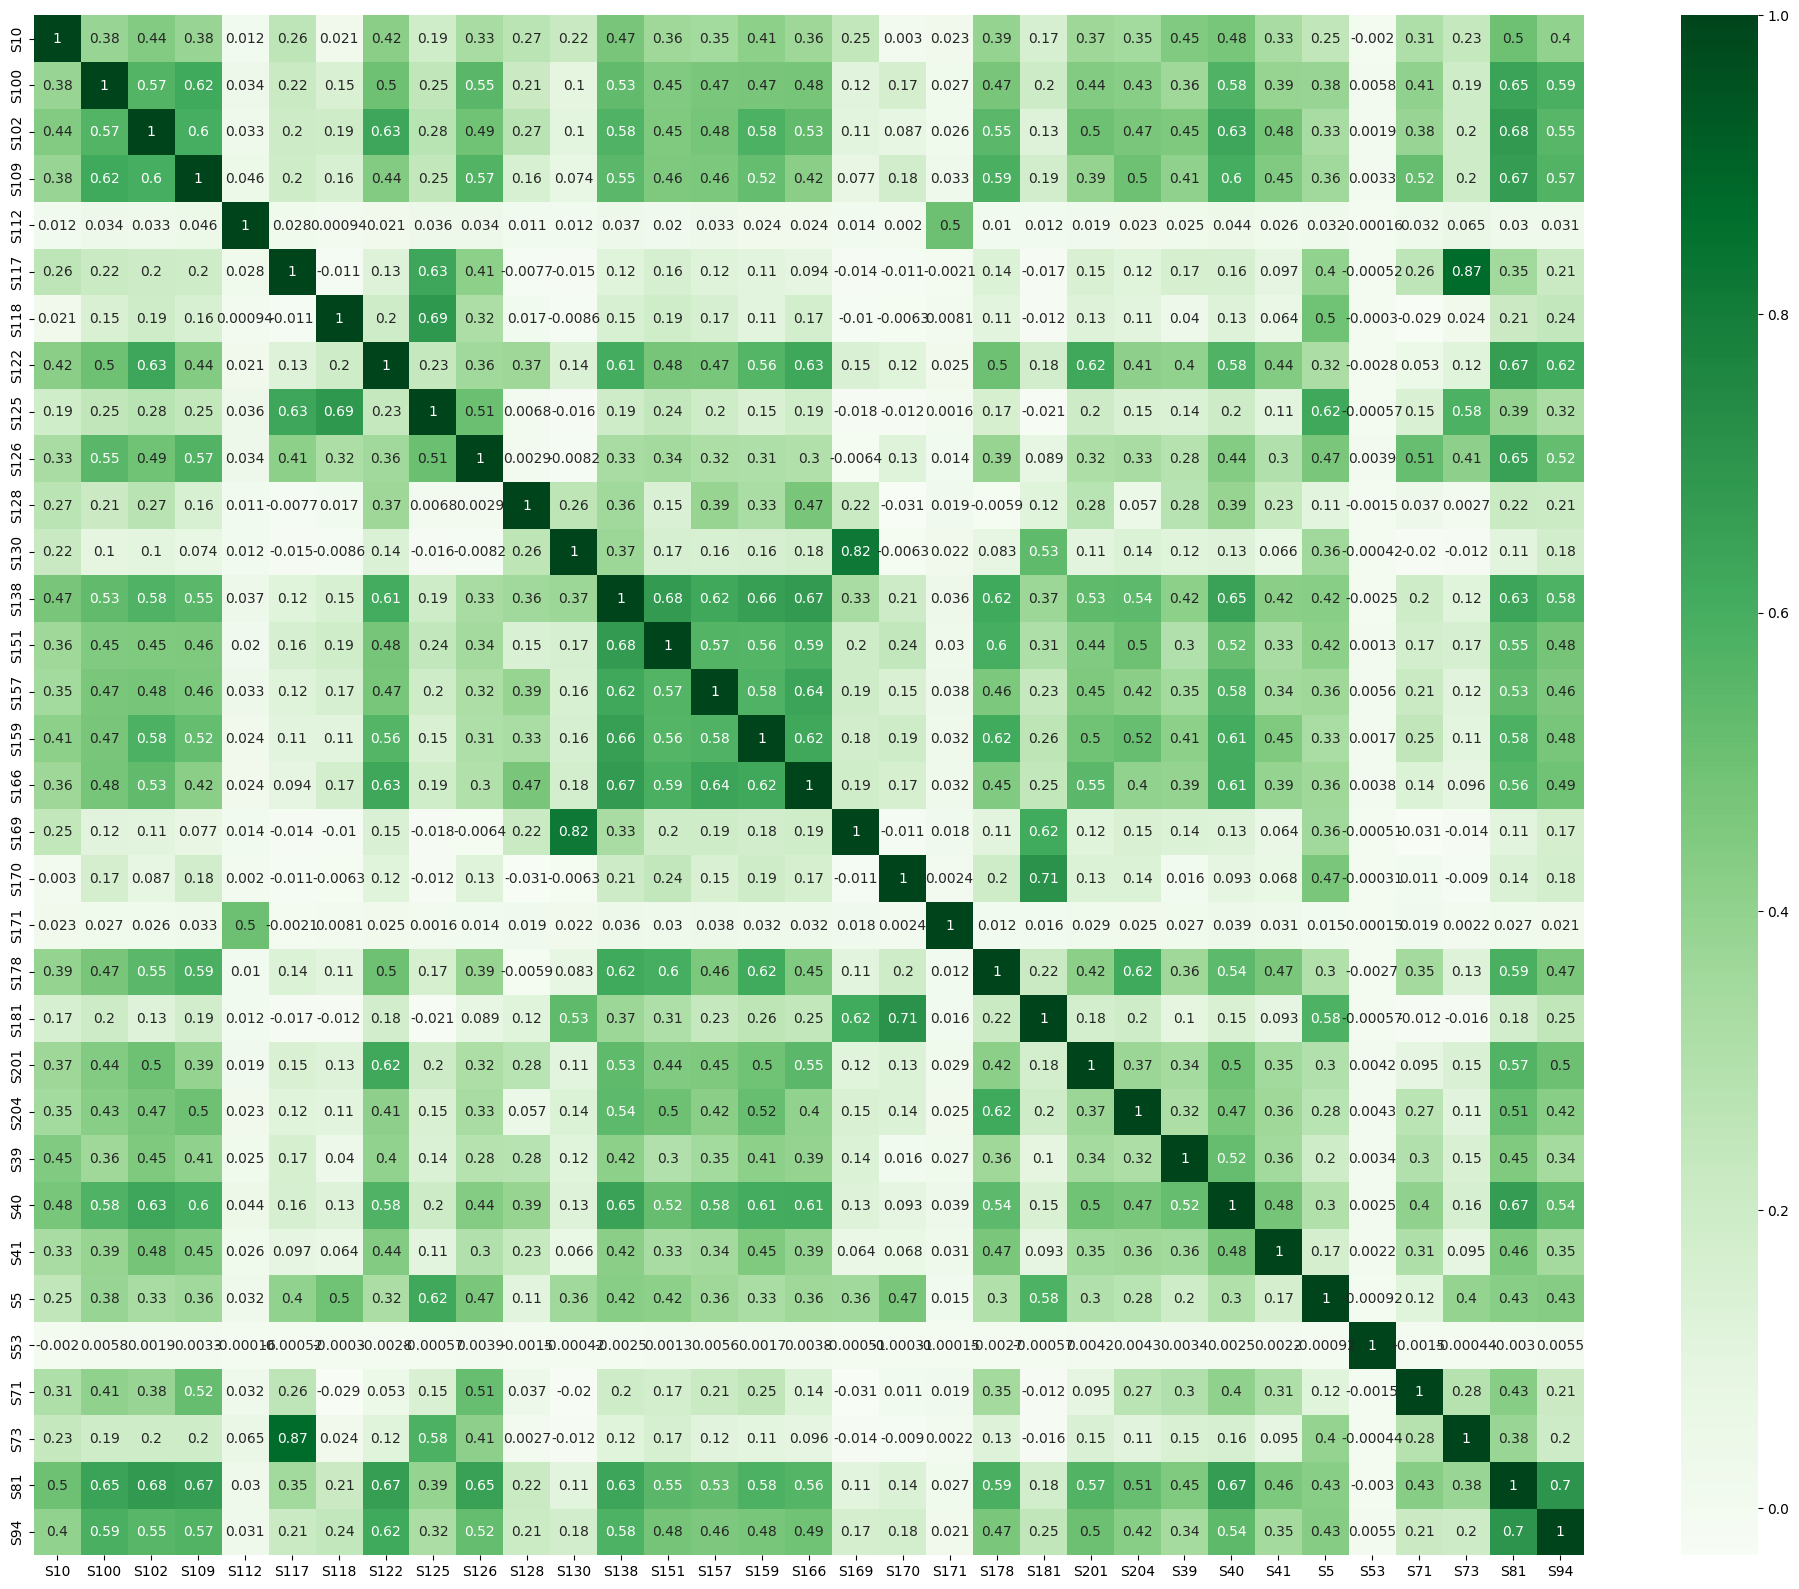

In [133]:
import seaborn as sns

# plot
plt.figure(figsize=(25,20))
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)

In [134]:
# comparing correlation with the engines
corr_cutoff = 0.6
corr_matrix_df[corr_matrix_df[metric_list[2:]] > corr_cutoff][metric_engines].set_axis(metric_list[2:])

,S117,S118,S169,S170
S10,NaN,NaN,NaN,NaN
S100,NaN,NaN,NaN,NaN
S102,NaN,NaN,NaN,NaN
S109,NaN,NaN,NaN,NaN
S112,NaN,NaN,NaN,NaN
S117,1.000000,NaN,NaN,NaN
S118,NaN,1.000000,NaN,NaN
S122,NaN,NaN,NaN,NaN
S125,0.630130,0.688105,NaN,NaN
S126,NaN,NaN,NaN,NaN


In [135]:
# this is why we delated the A5 and A9
corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_13/3864171821.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)


,S10,S100,S102,S109,S112,S117,S118,S122,S125,S126,S128,S130,S138,S151,S157,S159,S166,S169,S170,S171,S178,S181,S201,S204,S39,S40,S41,S5,S53,S71,S73,S81,S94
0,1.00,0.38,0.44,0.38,0.01,0.26,0.02,0.42,0.19,0.33,0.27,0.22,0.47,0.36,0.35,0.41,0.36,0.25,0.00,0.02,0.39,0.17,0.37,0.35,0.45,0.48,0.33,0.25,-0.00,0.31,0.23,0.50,0.40
1,0.38,1.00,0.57,0.62,0.03,0.22,0.15,0.50,0.25,0.55,0.21,0.10,0.53,0.45,0.47,0.47,0.48,0.12,0.17,0.03,0.47,0.20,0.44,0.43,0.36,0.58,0.39,0.38,0.01,0.41,0.19,0.65,0.59
2,0.44,0.57,1.00,0.60,0.03,0.20,0.19,0.63,0.28,0.49,0.27,0.10,0.58,0.45,0.48,0.58,0.53,0.11,0.09,0.03,0.55,0.13,0.50,0.47,0.45,0.63,0.48,0.33,0.00,0.38,0.20,0.68,0.55
3,0.38,0.62,0.60,1.00,0.05,0.20,0.16,0.44,0.25,0.57,0.16,0.07,0.55,0.46,0.46,0.52,0.42,0.08,0.18,0.03,0.59,0.19,0.39,0.50,0.41,0.60,0.45,0.36,0.00,0.52,0.20,0.67,0.57
4,0.01,0.03,0.03,0.05,1.00,0.03,0.00,0.02,0.04,0.03,0.01,0.01,0.04,0.02,0.03,0.02,0.02,0.01,0.00,0.50,0.01,0.01,0.02,0.02,0.03,0.04,0.03,0.03,-0.00,0.03,0.07,0.03,0.03
5,0.26,0.22,0.20,0.20,0.03,1.00,-0.01,0.13,0.63,0.41,-0.01,-0.01,0.12,0.16,0.12,0.11,0.09,-0.01,-0.01,-0.00,0.14,-0.02,0.15,0.12,0.17,0.16,0.10,0.40,-0.00,0.26,0.87,0.35,0.21
6,0.02,0.15,0.19,0.16,0.00,-0.01,1.00,0.20,0.69,0.32,0.02,-0.01,0.15,0.19,0.17,0.11,0.17,-0.01,-0.01,0.01,0.11,-0.01,0.13,0.11,0.04,0.13,0.06,0.50,-0.00,-0.03,0.02,0.21,0.24
7,0.42,0.50,0.63,0.44,0.02,0.13,0.20,1.00,0.23,0.36,0.37,0.14,0.61,0.48,0.47,0.56,0.63,0.15,0.12,0.02,0.50,0.18,0.62,0.41,0.40,0.58,0.44,0.32,-0.00,0.05,0.12,0.67,0.62
8,0.19,0.25,0.28,0.25,0.04,0.63,0.69,0.23,1.00,0.51,0.01,-0.02,0.19,0.24,0.20,0.15,0.19,-0.02,-0.01,0.00,0.17,-0.02,0.20,0.15,0.14,0.20,0.11,0.62,-0.00,0.15,0.58,0.39,0.32
9,0.33,0.55,0.49,0.57,0.03,0.41,0.32,0.36,0.51,1.00,0.00,-0.01,0.33,0.34,0.32,0.31,0.30,-0.01,0.13,0.01,0.39,0.09,0.32,0.33,0.28,0.44,0.30,0.47,0.00,0.51,0.41,0.65,0.52


In [136]:
# comparing correlation with the engines
corr_matrix_df[corr_matrix_df[metric_list[2:]] > 0.6][metric_engines].set_axis(metric_list[2:])

,S117,S118,S169,S170
S10,NaN,NaN,NaN,NaN
S100,NaN,NaN,NaN,NaN
S102,NaN,NaN,NaN,NaN
S109,NaN,NaN,NaN,NaN
S112,NaN,NaN,NaN,NaN
S117,1.000000,NaN,NaN,NaN
S118,NaN,1.000000,NaN,NaN
S122,NaN,NaN,NaN,NaN
S125,0.630130,0.688105,NaN,NaN
S126,NaN,NaN,NaN,NaN


**Notes:**
- S125 Capacity Circ 1 [%]
- S130 Compressor ON C2
- S181 Capacity Circ 2 [%] 
- S73 Compressor ON C1

- Filling missing values with a median

In [137]:
## Impute the missing data
from pyspark.ml.feature import Imputer

def impute_missing_data(df, column_names):
    #numeric_column_names = [column.name for column in df.schema.fields
                            #if isinstance(column.dataType, (F.IntegerType, F.FloatType, F.DoubleType))]

    # Initialize the Imputer
    imputer = Imputer(
        inputCols= column_names, #specifying the input column names
        outputCols= column_names, #specifying the output column names
        strategy="median"
        )
    # Fit the Imputer
    model = imputer.fit(df)

    #Transform the dataset
    imputed_df = model.transform(df)
    
    return imputed_df

df_sw065_imputed_2 = impute_missing_data(df_sw065_pivot, metric_list)

In [138]:
df_sw065_imputed_2.show()

+-------------------+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+----+----+----+---+---+---+---+----+---+
|               when| A5| A9|S10|S100|S102|S109|S112|S117|S118|S122|S125|S126|S128|S130|S138|S151|S157|S159|S166|S169|S170|S171|S178|S181| S201| S204| S39| S40| S41| S5|S53|S71|S73| S81|S94|
+-------------------+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+----+----+----+---+---+---+---+----+---+
|2020-10-01 00:02:00|  0|  0|100| 504| 720|2010|   1|   1|   0|1750| 200|  65| 320|   2| 260| 260| 485|1025|1862|   1|   0|   1|2180| 200|35895|35895| 750| 675| 386| 10|  0|330|  2| 225|260|
|2020-10-01 00:03:00|  0|  0|120| 504| 284| 784|   1|   1|   0|1750| 200| 100| 320|   2| 204| 260| 485| 765|1862|   1|   0|   1| 874| 200|35895|14366| 459| 496| 386| 10|  0|330|  2| 204|260|
|2020-10-01 00:04:00|  0|  0|125| 504| 705|19

In [139]:
# get the correlation matrix
corr_matrix_df_2 = get_correlation(df_sw065_imputed, metric_list[2:])

<Axes: >

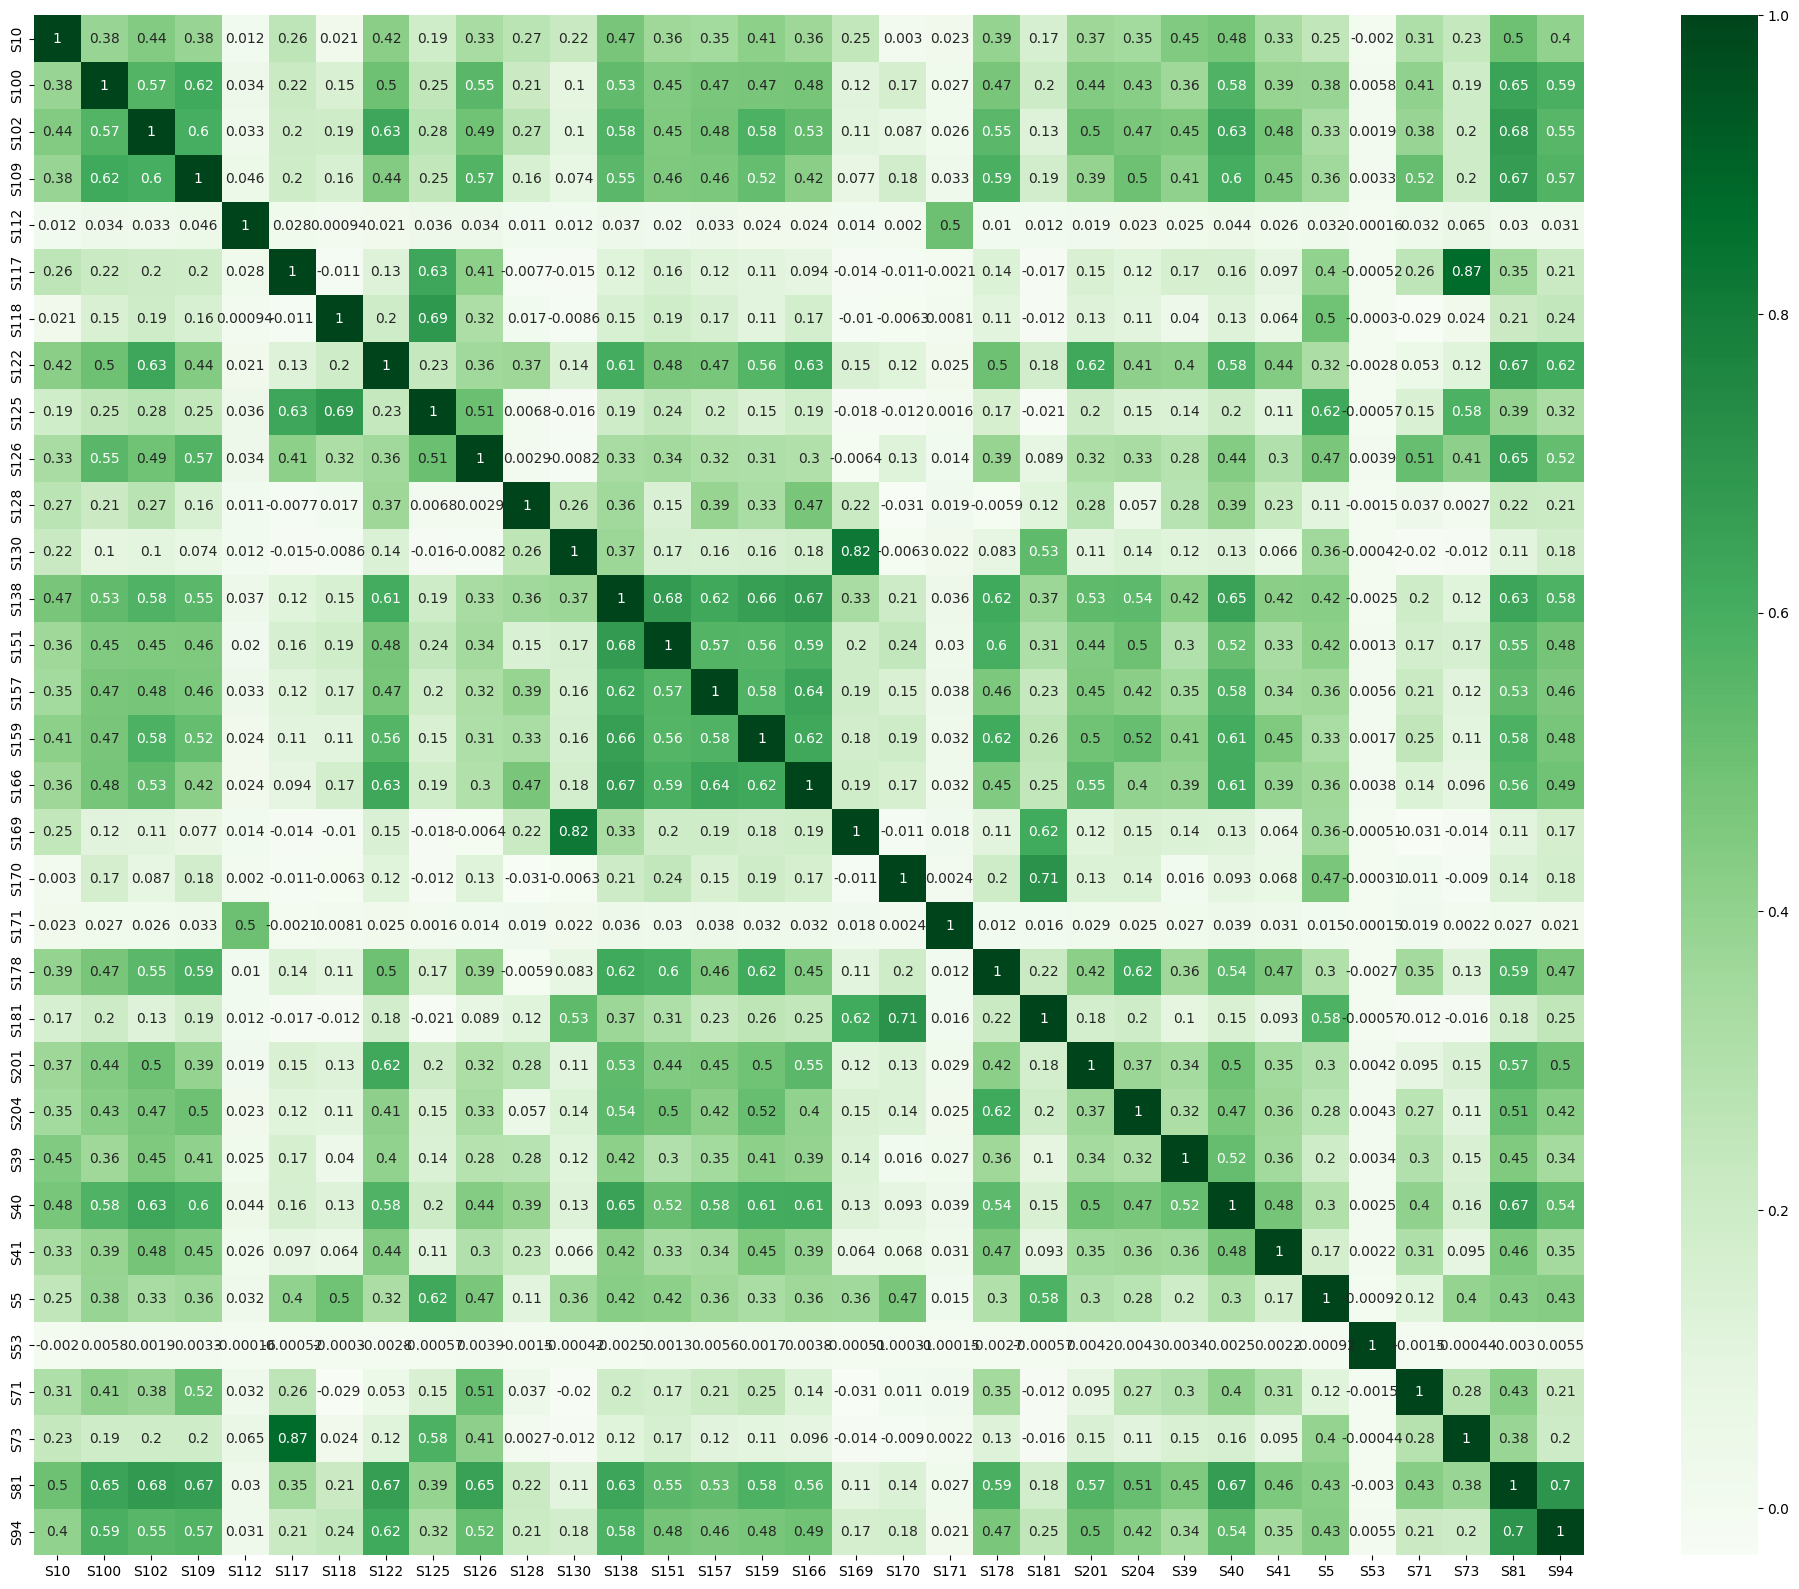

In [140]:
# plot
plt.figure(figsize=(25,20))
sns.heatmap(corr_matrix_df_2, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)

In [141]:
# other display of the correlation matrix
corr_matrix_df_2.set_axis(metric_list[2:]).style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_13/2751928140.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix_df_2.set_axis(metric_list[2:]).style.background_gradient(cmap='coolwarm').set_precision(2)


,S10,S100,S102,S109,S112,S117,S118,S122,S125,S126,S128,S130,S138,S151,S157,S159,S166,S169,S170,S171,S178,S181,S201,S204,S39,S40,S41,S5,S53,S71,S73,S81,S94
S10,1.00,0.38,0.44,0.38,0.01,0.26,0.02,0.42,0.19,0.33,0.27,0.22,0.47,0.36,0.35,0.41,0.36,0.25,0.00,0.02,0.39,0.17,0.37,0.35,0.45,0.48,0.33,0.25,-0.00,0.31,0.23,0.50,0.40
S100,0.38,1.00,0.57,0.62,0.03,0.22,0.15,0.50,0.25,0.55,0.21,0.10,0.53,0.45,0.47,0.47,0.48,0.12,0.17,0.03,0.47,0.20,0.44,0.43,0.36,0.58,0.39,0.38,0.01,0.41,0.19,0.65,0.59
S102,0.44,0.57,1.00,0.60,0.03,0.20,0.19,0.63,0.28,0.49,0.27,0.10,0.58,0.45,0.48,0.58,0.53,0.11,0.09,0.03,0.55,0.13,0.50,0.47,0.45,0.63,0.48,0.33,0.00,0.38,0.20,0.68,0.55
S109,0.38,0.62,0.60,1.00,0.05,0.20,0.16,0.44,0.25,0.57,0.16,0.07,0.55,0.46,0.46,0.52,0.42,0.08,0.18,0.03,0.59,0.19,0.39,0.50,0.41,0.60,0.45,0.36,0.00,0.52,0.20,0.67,0.57
S112,0.01,0.03,0.03,0.05,1.00,0.03,0.00,0.02,0.04,0.03,0.01,0.01,0.04,0.02,0.03,0.02,0.02,0.01,0.00,0.50,0.01,0.01,0.02,0.02,0.03,0.04,0.03,0.03,-0.00,0.03,0.07,0.03,0.03
S117,0.26,0.22,0.20,0.20,0.03,1.00,-0.01,0.13,0.63,0.41,-0.01,-0.01,0.12,0.16,0.12,0.11,0.09,-0.01,-0.01,-0.00,0.14,-0.02,0.15,0.12,0.17,0.16,0.10,0.40,-0.00,0.26,0.87,0.35,0.21
S118,0.02,0.15,0.19,0.16,0.00,-0.01,1.00,0.20,0.69,0.32,0.02,-0.01,0.15,0.19,0.17,0.11,0.17,-0.01,-0.01,0.01,0.11,-0.01,0.13,0.11,0.04,0.13,0.06,0.50,-0.00,-0.03,0.02,0.21,0.24
S122,0.42,0.50,0.63,0.44,0.02,0.13,0.20,1.00,0.23,0.36,0.37,0.14,0.61,0.48,0.47,0.56,0.63,0.15,0.12,0.02,0.50,0.18,0.62,0.41,0.40,0.58,0.44,0.32,-0.00,0.05,0.12,0.67,0.62
S125,0.19,0.25,0.28,0.25,0.04,0.63,0.69,0.23,1.00,0.51,0.01,-0.02,0.19,0.24,0.20,0.15,0.19,-0.02,-0.01,0.00,0.17,-0.02,0.20,0.15,0.14,0.20,0.11,0.62,-0.00,0.15,0.58,0.39,0.32
S126,0.33,0.55,0.49,0.57,0.03,0.41,0.32,0.36,0.51,1.00,0.00,-0.01,0.33,0.34,0.32,0.31,0.30,-0.01,0.13,0.01,0.39,0.09,0.32,0.33,0.28,0.44,0.30,0.47,0.00,0.51,0.41,0.65,0.52


In [142]:
# comparing correlation with the engines
corr_cutoff = 0.6
corr_matrix_df_2[corr_matrix_df_2[metric_list[2:]] > corr_cutoff][metric_engines].set_axis(metric_list[2:])

,S117,S118,S169,S170
S10,NaN,NaN,NaN,NaN
S100,NaN,NaN,NaN,NaN
S102,NaN,NaN,NaN,NaN
S109,NaN,NaN,NaN,NaN
S112,NaN,NaN,NaN,NaN
S117,1.000000,NaN,NaN,NaN
S118,NaN,1.000000,NaN,NaN
S122,NaN,NaN,NaN,NaN
S125,0.630130,0.688105,NaN,NaN
S126,NaN,NaN,NaN,NaN


**Notes:**
- S125 Capacity Circ 1 [%]
- S130 Compressor ON C2
- S181 Capacity Circ 2 [%] 
- S73 Compressor ON C1

### Machine SW088

We selected the same machine as before and filter by the windows with a frequency of turning Off-On of 5 min. This mean that its been 5 min from last turn Off.

In [147]:
# Add a lag column to calculate the difference 
window = Window.partitionBy("metric").orderBy("when")
df_sw088_1 = df_sw088_downsampling.withColumn("lag_value", F.lag(F.col("value")).over(window))

## ON and OFF events
df_sw088_1 = df_sw088_1.withColumn("ON-OFF", F.when(F.col("value") > F.col("lag_value"), 1).when((F.col("value") < F.col("lag_value")) | F.isnull(F.col("lag_value")) , -1).otherwise(0))

# time diff in seconds between turn ON and OFF
diff_btw_rows = F.unix_timestamp(F.col('when')) - F.unix_timestamp(F.lag(F.col('when'),1,0).over(window))

df_sw088_1 = df_sw088_1.filter(F.col('ON-OFF') != 0)
df_sw088_1 = df_sw088_1.withColumn('window', F.round(F.coalesce(diff_btw_rows, F.lit(0) )/60 ).cast('integer') )

#df_sw088_1 = df_sw088_1.persist()

In [148]:
df_sw088_1.show()

+-------------------+------+------+-----+---------+------+------+
|               when|  hwid|metric|value|lag_value|ON-OFF|window|
+-------------------+------+------+-----+---------+------+------+
|2020-10-01 00:00:00|SW-088|   S39|  102|     null|    -1|     0|
|2020-10-01 00:02:00|SW-088|   S39|  103|      102|     1|     2|
|2020-10-01 00:11:00|SW-088|   S39|  104|      103|     1|     9|
|2020-10-01 00:12:00|SW-088|   S39|  103|      104|    -1|     1|
|2020-10-01 00:13:00|SW-088|   S39|  104|      103|     1|     1|
|2020-10-01 00:22:00|SW-088|   S39|  105|      104|     1|     9|
|2020-10-01 00:23:00|SW-088|   S39|  104|      105|    -1|     1|
|2020-10-01 00:24:00|SW-088|   S39|  105|      104|     1|     1|
|2020-10-01 00:25:00|SW-088|   S39|  104|      105|    -1|     1|
|2020-10-01 00:26:00|SW-088|   S39|  105|      104|     1|     1|
|2020-10-01 00:34:00|SW-088|   S39|  106|      105|     1|     8|
|2020-10-01 00:38:00|SW-088|   S39|  105|      106|    -1|     4|
|2020-10-0

In [149]:
# filtered by most frequent window
window_cutoff = 5
df_sw088_when_hig_freq = df_sw088_1.filter((F.col('ON-OFF') == 1) & (F.col('window') < window_cutoff)).select('when').sort('when')

# join tables
df_sw088_hig_freq = df_sw088_1.join(df_sw065_when_hig_freq, how='inner', on='when').sort(F.col('when'))

df_sw088_hig_freq = df_sw088_hig_freq.select('when','metric','value')#.persist()
#df_sw088_hig_freq.unpersist()

In [150]:
# get a list of metrics
metric_list_3 = df_sw088_hig_freq.select('metric').distinct().rdd.map(lambda x: x.metric).collect()
metric_list_3.sort()

In [151]:
print(metric_list_3)

['A5', 'A9', 'ComError', 'P1', 'P10', 'P16', 'P5', 'P6', 'P7', 'P8', 'P9', 'S10', 'S100', 'S101', 'S102', 'S107', 'S109', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S151', 'S154', 'S157', 'S158', 'S159', 'S164', 'S166', 'S169', 'S170', 'S171', 'S172', 'S173', 'S174', 'S178', 'S179', 'S180', 'S181', 'S183', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S35', 'S37', 'S39', 'S40', 'S41', 'S46', 'S47', 'S5', 'S53', 'S55', 'S6', 'S64', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA2', 'SA3', 'SA5', 'SA7', 'SA9']


In [152]:
# pivot the dataframe - converts rows to column
df_sw088_pivot = df_sw088_hig_freq.groupby('when').pivot('metric').sum('value')


In [153]:
# call function for missing values
missing_values_col = find_column_missing_percentage(df_sw088_pivot)

In [154]:
# See results
missing_values_col.show(140)

+---------+---------------+
|Variables|Percent_Missing|
+---------+---------------+
|       P5|          100.0|
|       P9|          100.0|
|       P6|          100.0|
| ComError|          100.0|
|      P10|          100.0|
|     SA10|          100.0|
|      SA7|          100.0|
|       P7|          100.0|
|     SA11|          100.0|
|      S25|          100.0|
|      SA1|          100.0|
|      SA2|          100.0|
|       P8|          100.0|
|      SA5|          100.0|
|       A5|          99.99|
|       S8|          99.99|
|      SA9|          99.99|
|      S35|          99.99|
|       P1|          99.99|
|      P16|          99.99|
|      S55|          99.99|
|       S6|          99.99|
|      S33|          99.99|
|      SA3|          99.99|
|       A9|          99.98|
|       S2|          99.98|
|       S7|          99.97|
|      S53|          99.95|
|     S183|          99.95|
|     S127|          99.93|
|     S115|          99.89|
|     S174|          99.89|
|       S3|         

In [155]:
# Fill missing values with a default value
default_value = 0
df_sw088_imputed = df_sw088_pivot.fillna(default_value)

In [156]:
# Get the correlation matrix
corr_matrix_df_sw088 = get_correlation(df_sw088_imputed, metric_list_3)

24/07/08 09:01:56 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


In [157]:
# Comparing correlation with the engines
corr_cutoff = 0.6
corr_matrix_df_sw088[corr_matrix_df_sw088[metric_list_3] > corr_cutoff][metric_engines].set_axis(metric_list_3).dropna(how='all')

,S117,S118,S169,S170
S117,1.0,NaN,NaN,NaN
S118,NaN,1.000000,NaN,NaN
S125,NaN,0.755074,NaN,NaN
S130,NaN,NaN,NaN,0.635380
S169,NaN,NaN,1.0,NaN
S170,NaN,NaN,NaN,1.000000
S181,NaN,NaN,NaN,0.774499
S73,NaN,0.633477,NaN,NaN


**Notes:**
- S125 Capacity Circ 1 %
- S130 Compressor ON C2 
- S181 Capacity Circ 2 %
- S73 Compressor ON C1

#### What happens if we don't filter by most frequent values?

- SW065

In [158]:
# get a list of metrics
metric_list_2 = df_sw065_downsampling.select('metric').distinct().rdd.map(lambda x: x.metric).collect()
metric_list_2.sort()

In [159]:
print(metric_list_2)

['A5', 'A9', 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']


In [160]:
# Pivot the dataframe - converts rows to column
df_sw065_pivot = df_sw065_downsampling.groupby('when').pivot('metric').sum('value')

In [161]:
# Call function
missing_values_col = find_column_missing_percentage(df_sw065_pivot)

In [162]:
missing_values_col.show(140)

+---------+---------------+
|Variables|Percent_Missing|
+---------+---------------+
|       A5|          99.89|
|       A9|          99.89|
|     S169|            2.7|
|     S170|            2.7|
|     S140|            2.7|
|     S171|            2.7|
|     S158|            2.7|
|     S172|            2.7|
|     S173|            2.7|
|     S143|            2.7|
|     S159|            2.7|
|     S174|            2.7|
|     S175|            2.7|
|     S147|            2.7|
|     S163|            2.7|
|     S151|            2.7|
|     S180|            2.7|
|     S164|            2.7|
|     S203|            2.7|
|     S165|            2.7|
|     S204|            2.7|
|     S181|            2.7|
|     S205|            2.7|
|     S166|            2.7|
|     S206|            2.7|
|     S179|            2.7|
|     S154|            2.7|
|     S183|            2.7|
|     S167|            2.7|
|     S201|            2.7|
|     S176|            2.7|
|     S202|            2.7|
|     S157|         

In [163]:
# Fill missing values with a default value
default_value = 0
df_sw065_imputed = df_sw065_pivot.fillna(default_value)

#df_sw065_imputed.show()

In [164]:
# Get the correlation matrix
corr_matrix_df_3 = get_correlation(df_sw065_imputed, metric_list_2[2:-1])

24/07/08 09:05:11 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


In [165]:
corr_matrix_df_3.dropna(how='all')

,P1,P10,P15,P16,P17,P18,P2,P5,P6,P7,...,SA11,SA12,SA2,SA3,SA4,SA5,SA6,SA7,SA8,SA9
0,1.000000,0.999058,NaN,0.999529,0.999058,0.999058,NaN,0.999058,0.998588,0.999058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.999058,1.000000,NaN,0.999529,0.999058,0.999058,NaN,0.999058,0.998588,0.999058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.999529,0.999529,NaN,1.000000,0.999529,0.999529,NaN,0.999529,0.999058,0.999529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.999058,0.999058,NaN,0.999529,1.000000,0.999058,NaN,0.999058,0.998588,0.999058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [166]:
# Comparing correlation with the engines
corr_cutoff = 0.6
corr_matrix_df_3[corr_matrix_df_3[metric_list_2[2:-1]] > corr_cutoff][metric_engines].set_axis(metric_list_2[2:-1]).dropna(how='all')

,S117,S118,S169,S170
S10,0.685599,NaN,0.640560,NaN
S102,0.850733,NaN,NaN,NaN
S109,0.812129,NaN,NaN,NaN
S112,0.636636,NaN,NaN,NaN
S117,1.000000,NaN,NaN,NaN
S118,NaN,1.0,NaN,NaN
S122,0.821490,NaN,NaN,NaN
S125,0.858981,NaN,NaN,NaN
S126,0.853444,NaN,NaN,NaN
S130,NaN,NaN,0.895732,NaN


**Notes:**
- S10 Utility Request % 
- S102 Discharge Pressure Circ 1 bar
- S109 Discharge Temperature C1,1 °C
- S112 4 Way Valve Circ 1 
- S122 Signal Inverter Fan Circ 1 V
- S125 Capacity Circ 1 %
- S126 Pressure Ratio Circ 1
- S130 Compressor ON C2
- S151 EEV Position PID1 Circ 2 %
- S159 Discharge Pressure Circ 2 bar
- S166 Discharge Temperature C1,2
- S171 4 Way Valve Circ 2
- S178 Signal Inverter Fan Circ 2 V
- S181 Capacity Circ 2 %
- S5 Corrent Power Steps
- S73 Compressor ON C1
- S94 EEV Position PID1 Circ 1 %

- SW088

In [167]:
# get a list of metrics
metric_list_sw088 = df_sw088_downsampling.select('metric').distinct().rdd.map(lambda x: x.metric).collect()
metric_list_sw088.sort()

In [168]:
print(metric_list_sw088)

['A5', 'A9', 'ComError', 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']


In [169]:
# pivot the dataframe - converts rows to column
df_sw088_pivot = df_sw088_downsampling.groupby('when').pivot('metric').sum('value')

In [170]:
# call function
missing_values_col = find_column_missing_percentage(df_sw088_pivot)


In [171]:
# See results
missing_values_col.show(140)

+---------+---------------+
|Variables|Percent_Missing|
+---------+---------------+
| ComError|          99.99|
|       A5|          99.89|
|       A9|          99.86|
|     S165|           2.58|
|     S166|           2.58|
|     S138|           2.58|
|     S167|           2.58|
|     S151|           2.58|
|     S169|           2.58|
|     S154|           2.58|
|     S170|           2.58|
|     S171|           2.58|
|     S172|           2.58|
|     S157|           2.58|
|     S173|           2.58|
|     S137|           2.58|
|     S174|           2.58|
|     S180|           2.58|
|     S175|           2.58|
|     S203|           2.58|
|     S159|           2.58|
|     S204|           2.58|
|     S140|           2.58|
|     S181|           2.58|
|     S158|           2.58|
|     S205|           2.58|
|     S163|           2.58|
|     S206|           2.58|
|     S179|           2.58|
|     S143|           2.58|
|     S183|           2.58|
|     S164|           2.58|
|     S201|         

In [172]:
# Fill missing values with a default value
default_value = 0
df_sw088_imputed = df_sw088_pivot.fillna(default_value)

In [173]:
# Get the correlation matrix
corr_matrix_df_sw088 = get_correlation(df_sw088_imputed, metric_list_sw088)

24/07/08 09:16:43 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


In [174]:
# Comparing correlation with the engines
corr_cutoff = 0.6
corr_matrix_df_sw088[corr_matrix_df_sw088[metric_list_sw088] > corr_cutoff][metric_engines].set_axis(metric_list_sw088).dropna(how='all')

,S117,S118,S169,S170
S109,0.665932,0.825593,NaN,NaN
S117,1.000000,NaN,NaN,NaN
S118,NaN,1.000000,NaN,NaN
S122,0.623934,0.892108,NaN,NaN
S125,0.706098,0.941666,NaN,NaN
S126,0.623201,0.788779,NaN,NaN
S130,NaN,NaN,0.797633,0.828054
S166,NaN,NaN,0.624053,0.736908
S169,NaN,NaN,1.000000,NaN
S170,NaN,NaN,NaN,1.000000


Notes:
- S109 Discharge Temperature C1,1 °C
- S122 Signal Inverter Fan Circ 1 V
- S125 Capacity Circ 1 %
- S126 Pressure Ratio Circ 1
- S130 Compressor ON C2
- S166 Discharge Temperature C1,2

- S171 4 Way Valve Circ 2
- S178 Signal Inverter Fan Circ 2 V
- S181 Capacity Circ 2 %
- S5 Corrent Power Steps
- S73 Compressor ON C1
- S94 EEV Position PID1 Circ 1 %

# STOP worker and master

In [6]:
#sc.stop()
spark.stop()